# Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Author: Sanjay Kottapalli, Dana Pe'er lab (kottapas@mskcc.org)

import numpy as np
import numpy.matlib
import pandas as pd
import scanpy as sc
from scanpy.external.pp import magic
import scipy
from sklearn.metrics import adjusted_rand_score
from scipy.stats.mstats import zscore
from scipy.stats import pearsonr
import csv
import os
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from copy import deepcopy
import timeit
from joblib import Parallel, delayed
from collections import Counter
np.random.seed(0)

# Define functions

In [3]:
def import_seqc_data(sample_name, path, dense=True):
    print('\nsample: ' + sample_name)
    if dense:
        PATH_TO_COUNT_CSV = path + sample_name + '_dense.csv'
        # import csv
        raw_counts = pd.read_csv(PATH_TO_COUNT_CSV, index_col=0, header=0)
        print(raw_counts.shape)
        #
        with open(PATH_TO_COUNT_CSV, "r") as f:
            reader = csv.reader(f)
            original_column_names = next(reader)
        # remove the first entry of this list, it belongs to the index column
        gene_names = original_column_names[1:]
        # and label the index column with name 'cell_barcodes'
        raw_counts.index.name = 'cell_barcodes'
        # convert indices to strings instead of integers for compatibility with scanpy
        raw_counts.index = raw_counts.index.astype(str)
        # python automatically converts duplicate column names to numbered column names,
        # e.g. 'X', 'X.1', 'X.2' etc. We can import the original column names from our CSV file:

        # now transpose the dataframe (for compatibility with panda's groupby function), 
        # then group by gene names, and add up the counts for genes with the same name
        raw_counts_transposed = raw_counts.T
        raw_counts_transposed_clean = raw_counts_transposed.groupby(gene_names, axis='index', sort=False).agg('sum')
        # transpose back
        raw_counts_clean = raw_counts_transposed_clean.T
        # if columns were added up, print how many:
        number_of_columns_removed = raw_counts.shape[1] - raw_counts_clean.shape[1]
        if number_of_columns_removed > 0:
            print(str(number_of_columns_removed) + ' columns were each merged with another column that had the same gene name.')
        # remove CLUSTER column:
        if 'CLUSTER' in raw_counts_clean.columns:
            raw_counts_clean.drop(columns='CLUSTER', inplace=True)
        # convert index type to string for compatibility with scanpy
        raw_counts_clean.index = raw_counts_clean.index.astype('str')
        adata = sc.AnnData(X = raw_counts_clean)
    else:
        barcodes = pd.read_csv(path+sample_name+'_sparse_counts_barcodes.csv', index_col=0, header=None)
        barcodes = barcodes[1].values
        barcodes = [str(i) for i in barcodes]
        gene_names = pd.read_csv(path+sample_name+'_sparse_counts_genes.csv', index_col=0, header=None)
        gene_names = gene_names[1].values
        sparse_counts = scipy.io.mmread(path+sample_name+'_sparse_molecule_counts.mtx').tocsc()
        #print("# of bytes: "+str(sparse_counts.data.nbytes))
        print(sparse_counts.shape)
        #sparse_counts = sparse_counts.toarray()#np.array(sparse_counts)
        #print(sparse_counts.shape)
        #raw_counts = pd.DataFrame.sparse.from_spmatrix(data=sparse_counts, index=barcodes, columns=gene_names)
        
        gene_dup = pd.Series(dict(Counter(gene_names)))
        gene_dup = gene_dup[gene_dup>1]
        #print(gene_dup)
        #print(len(set(gene_names)))
        gene_dup = list(gene_dup.keys())
        number_of_columns_removed = len(gene_dup)
        
        # sum of duplicate columns for each duplicate gene
        sum_dict = {i:sparse_counts[:,np.where(gene_names==i)[0]].sum(axis=1) for i in gene_dup}
        dup_index = []
        for i in gene_dup:
            dup_index += list(np.where(gene_names==i)[0])
        #print(sum_dict)
        #print(len(dup_index))
        #for i in sum_dict:
        #    print(sum_dict[i].sum(axis=0))
        
        #print(len(gene_names), sparse_counts.shape)
        keep_index = list(set(range(len(gene_names))) - set(dup_index))
        new_genes = list(gene_names[keep_index])
        new_counts = sparse_counts[:, keep_index]
        #print(len(new_genes), new_counts.shape)
        #print(new_counts.shape, type(new_counts))
        for i in sum_dict.keys():
            #print(sum_dict[i])
            #print(type(new_counts), type(sum_dict[i]))
            new_counts = scipy.sparse.hstack([new_counts, sum_dict[i]])
            new_genes.append(i)
        #print(len(new_genes), new_counts.shape)
        new_counts = new_counts.tocsc()
        print(new_counts.shape)#, type(new_counts))
        
        adata = sc.AnnData(X = new_counts, obs=pd.DataFrame(index=barcodes), var=pd.DataFrame(index=new_genes))
        
        if number_of_columns_removed > 0:
            print(str(number_of_columns_removed) + ' columns were each merged with another column that had the same gene name.')
       # take the min libsize in the dense cells, and 
        
        adata, mito_genes, RB_genes_in_data = qc_metrics(adata)
        # remove high mito frac cells
        cutoff = 20.0
        mito_val = adata.obs['pct_counts_mito']
        #print(mito_val)
        via_cells = mito_val[mito_val<cutoff]
        #print(via_cells)
        adata = adata[via_cells.index, :]
        print(adata.shape)
        
        PATH_TO_COUNT_CSV = path + sample_name + '_dense.csv'
        raw_counts = pd.read_csv(PATH_TO_COUNT_CSV, index_col=0, header=0)
        seqc_cells = [str(i) for i in raw_counts.index]
        libsize = adata.obs['original_total_counts'].sort_values(ascending=False)
        #pd.Series(index=adata.obs.index, data=np.array(np.sum(adata.X, axis=1).flatten())[0], dtype=str).sort_values(ascending=False)
        
        #difference = set(seqc_cells)-set([str(i) for i in libsize.iloc[:len(seqc_cells)+15000].index])
        #print(len(seqc_cells),len(difference))
        #print(seqc_cells[:20])
        #print(libsize.iloc[:20])
        
        adata = adata[libsize.iloc[:len(seqc_cells)+15000].index, :] # all dense cells + 15,000
        adata = sc.AnnData(X = adata.X, obs=pd.DataFrame(index=adata.obs.index), var=pd.DataFrame(index=adata.var.index))
        print(adata.shape)
        print("Cells filtered.")
    
    return adata

In [4]:
def qc_metrics(adata, path_RB=''):
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.var['mito'] = mito_genes
    mito_genes = np.array(adata.var.index)[mito_genes]
    
    path_RB = path_RB+'RB_genes_human'
    with open(path_RB,'r') as file:
        lines = file.readlines()
    RB_genes = [x.rstrip('\n') for x in lines]
    data_genes = list(adata.var.index)
    RB_genes_in_data = set(data_genes).intersection(RB_genes)
    RB_genes_in_data = list(RB_genes_in_data)
    
    adata.var['ribo'] = False
    adata.var.loc[RB_genes_in_data, 'ribo'] = True
    
    sc.pp.calculate_qc_metrics(adata, qc_vars=('mito', 'ribo'), inplace=True)
    adata.obs['original_total_counts'] = adata.obs['total_counts']
    adata.obs['log10_original_total_counts'] = np.log10(adata.obs['original_total_counts'])
    print('QC metrics calculated.')
    
    return adata, mito_genes, RB_genes_in_data

In [5]:
def norm_filter(adata, mito_genes, RB_genes_in_data, log=True, remove_ribo=True, remove_mito=True, highly_var=False, markers=[]):
    
    adata.layers['raw_counts'] = adata.X
    # filter genes expressed in few cells
    print(adata.shape)
    sc.pp.filter_genes(adata, min_cells = 10)
    print(adata.shape)
    
    # libsize normalize
    if type(adata.X)==np.ndarray:
        med_libsize = np.median(np.sum(adata.X, axis=1))
    else:
        sums = np.array(np.sum(adata.X, axis=1).flatten())[0]
        #med_libsize = np.median(sums)
        if min(sums) == 0:
            empty_cells = set(np.where(sums==0)[0])
            print('# of 0-count droplets: '+str(len(empty_cells)))
            all_cells = set(adata.obs.index)
            keep_cells = all_cells-empty_cells
            adata = adata[keep_cells, :]
            sums = np.array(np.sum(adata.X, axis=1).flatten())[0]
        med_libsize = np.median(sums)

        print('Median library size: ' + str(med_libsize))

    sc.pp.normalize_total(adata)

    # log transform
    if log:
        adata.X = np.log2(adata.X+0.1) - np.log2(0.1)

        for i in deepcopy(markers):
            try:
                adata.obs[i+'_exp'] = adata[:,i].X
            except:
                markers.remove(i)
                print(i)

    else:
        print('unlogged')
        for i in deepcopy(markers):
            try:
                adata.obs[i+'_exp'] = np.log2(adata[:,i].X+0.1)
            except:
                markers.remove(i)
                print(i)

    # remove ribosomal genes
    if remove_ribo:
        RB_genes_in_data.append('MALAT1')
        adata = adata[:,[x not in RB_genes_in_data for x in adata.var.index]]
        print(adata.shape)

    # remove mitochondrial genes
    if remove_mito:
        adata = adata[:,[x not in mito_genes for x in adata.var.index]]
        print(adata.shape)

    # highly variable gene selection
    print(highly_var)
    if highly_var:
        if not log:
            print('Im here1')
            sc.pp.highly_variable_genes(adata, layer='raw_counts', flavor='seurat_v3',max_mean=np.inf, n_top_genes=2000)#, batch_key='Sample ID')
            print(sum(adata.var['highly_variable']))
            adata.var.loc[markers, 'highly_variable'] = True
            print(sum(adata.var['highly_variable']))
            print(adata.shape)
        elif log:
            print('Im here2')
            sc.pp.highly_variable_genes(adata, layer=None, flavor='cell_ranger', max_mean=np.inf, n_top_genes=2000)#, batch_key='Sample ID')
            print(sum(adata.var['highly_variable']))
            adata.var.loc[markers, 'highly_variable'] = True
            print(sum(adata.var['highly_variable']))

    return adata, markers#adata_unlog, markers

In [6]:
def plot_pca(adata):
    #print("I am in here 1")
    
    print(adata.X)
    try:
        print(adata.shape)
        N = 1000
        adata_new = sc.tl.pca(adata, n_comps=N, copy = True)
    except:
        print(adata.shape) 
        N = min(adata.shape) - 1
        adata_new = sc.tl.pca(adata, n_comps=N, copy = True)
    
    #Plot variance explained
    x = range(len(adata_new.uns['pca']['variance_ratio']))
    y = adata_new.uns['pca']['variance_ratio']
    plt.scatter(x,y,s=4)
    plt.xlabel('PC')
    plt.ylabel('Fraction of variance explained')
    plt.title('Fraction of variance explained per PC')
    plt.show()
    
    #Plot cumulative variance
    cml_var_explained = np.cumsum(adata_new.uns['pca']['variance_ratio'])
    x = range(len(adata_new.uns['pca']['variance_ratio']))
    y = cml_var_explained
    plt.scatter(x,y,s=4)
    plt.xlabel('PC')
    plt.ylabel('Cumulative fraction of variance explained')
    plt.title('Cumulative fraction of variance explained by PCs')
    plt.show()
    
    return cml_var_explained, adata_new.uns['pca']['variance_ratio']
    
def kneepoint(vec):
    #print("I am in here 4")
    curve =  [1-x for x in vec]
    nPoints = len(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * numpy.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    
    return idxOfBestPoint
    
def run_pca_knee(adata):
    cml, var = plot_pca(adata)

    knee = kneepoint(var)
    
    print("Knee point: "+str(knee))
    print("Explained variance: " + str(cml[knee]))

    x=list(range(len(cml)))
    plt.plot(x[:5*knee],cml[:5*knee])
    plt.show()

    adata_new = sc.tl.pca(adata, n_comps=knee+1, copy=True)
    sc.pl.pca_loadings(adata_new, components=range(1,4))
    
    return adata_new

In [7]:
def files_MAST(adata, cell_type = '', outdir = ''):
    
    # if directory doesn't exist, create it
    if not os.path.exists('DEA/' + cell_type):
        os.makedirs('DEA/' + cell_type)
    
    adata_celltype = deepcopy(adata)
    #adata_celltype = adata_celltype[adata_celltype.obs['final_subclusters'].isin([cell_type]),:]
    print(cell_type + '\t'+"Dimensions" + "\t"+ "{}".format(adata_celltype.shape))
    
    # make a dataframe for the expression matrix
    expmat = pd.DataFrame(adata_celltype.X, columns = adata_celltype.var.index, index = adata_celltype.obs.index)

    # make a dataframe for the observation data
    cdata = pd.DataFrame(adata_celltype.obs, columns=adata_celltype.obs.columns, index = adata_celltype.obs.index)

    
    expmat.to_csv(r'DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv', index=True)
    cdata.to_csv(r'DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv', index=True)
    
    print("Files written for {}".format(cell_type))

In [8]:
def run_MAST_for_celltype(adata, cell_type):
    start_time = timeit.default_timer()
    MAST = './runMAST.R'
    
    # run 
    files_MAST(adata = adata, cell_type = cell_type)
    
    expmat_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
    cdata_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
    output_file_cort = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_cort.csv" 
    output_file_bs = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_bs.csv" 
    
    print("Running " + MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " + output_file_bs)
    
    os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " + output_file_bs)
    out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)
    
    return out_str

In [9]:
godsnot_64 = [
    # "#000000",  # remove the black, as often, we have black colored annotation
    "#d9d929", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#6A3A4C", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72"]

# Populate input parameters

In [10]:
# populate from command line
samples = ['1819_C1029_Ctrl_ES_Cort_IGO_10837_23', '1820_C1029_Ctrl_ES_BS_IGO_10856_3', '1821_996_VE_ES_Cort_IGO_10875_6', '1822_996_VE_ES_BS_IGO_10875_7']
indir = '../input/'
outdir = '../output_Nov/'
figures = '../figures/'

In [11]:
adata_final_high_var = sc.read_h5ad(outdir+'adata_final_high_var_final_clusters_updated.h5ad')

In [12]:
adata_final_high_var.shape

(23060, 18947)

# Microglia subset

In [13]:
adata_microglia = deepcopy(adata_final_high_var)
adata_microglia = adata_microglia[adata_microglia.obs['final_subclusters'].isin(['microglia']),:]
adata_microglia.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(697, 18947)

In [11]:
broad_clusters = adata_microglia.obs['Condition']
unique_clusters = np.unique(broad_clusters.values)
samples = adata_microglia.obs['Sample ID']
print('Cell counts in each cluster for each sample: ')

for cluster in unique_clusters:
    print('Cluster: '+str(cluster))
    index = broad_clusters[broad_clusters==cluster].index
    count = Counter(samples[index].values)
    print(count)

NameError: name 'adata_microglia' is not defined

In [15]:
path_to_h5ad_file = outdir+'adata.h5ad'
adata = sc.read_h5ad(path_to_h5ad_file)
print(adata)
# Add a new column describing the sample condition
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1819_C1029_Ctrl_ES_Cort_IGO_10837_23', "Control", "NA")
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1820_C1029_Ctrl_ES_BS_IGO_10856_3', "Control", adata.obs['Condition'])
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1821_996_VE_ES_Cort_IGO_10875_6', "VE", adata.obs['Condition'])
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1822_996_VE_ES_BS_IGO_10875_7', "VE", adata.obs['Condition'])


adata.obs.head()

AnnData object with n_obs × n_vars = 26101 × 22292
    obs: 'Sample ID'


Sample ID  \
cell_barcodes                                                                              
120703436570020_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455227244_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455251884_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455704877_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120718441244516_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   

                                                   Condition  
cell_barcodes                                                 
120703436570020_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455227244_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455251884_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455704877_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120718441244516_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control

In [16]:
# Add a new column describing the sample condition
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1819_C1029_Ctrl_ES_Cort_IGO_10837_23', "Cortex", "NA")
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1820_C1029_Ctrl_ES_BS_IGO_10856_3', "BrainStem", adata.obs['B_region'])
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1821_996_VE_ES_Cort_IGO_10875_6', "Cortex", adata.obs['B_region'])
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1822_996_VE_ES_BS_IGO_10875_7', "BrainStem", adata.obs['B_region'])


#adata.obs
# count the number of NAs
sum(pd.isna(adata.obs['B_region']))

0

In [17]:
adata_microglia = adata[adata_microglia.obs.index, :]
adata_microglia.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(697, 22292)

## QC

In [18]:
adata_microglia, mito_genes, RB_genes_in_data = qc_metrics(adata_microglia)
markers = []
if type(adata_microglia.X)==np.ndarray:
    pass
else:
    print(type(adata_microglia.X))
    #print(adata_norm.X.shape)
    adata_microglia.X = adata_microglia.X.toarray()
    #print(adata_norm.X.shape)
adata_microglia.X = pd.DataFrame(data=adata_microglia.X).fillna(0).values

Trying to set attribute `.var` of view, copying.


QC metrics calculated.
<class 'scipy.sparse.csr.csr_matrix'>


In [19]:
adata_microglia.shape

(697, 22292)

## Normalization

In [20]:
markers = []
adata_microglia, markers = norm_filter(adata_microglia, mito_genes, RB_genes_in_data, markers=[], highly_var=True)
adata_microglia.obs.head()

(697, 22292)
(697, 9955)
(697, 9810)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


(697, 9799)
True
Im here2
1999
1999


Sample ID  \
cell_barcodes                                                                              
231906420636590_1822_996_VE_ES_BS_IGO_10875_7              1822_996_VE_ES_BS_IGO_10875_7   
131165995285419_1822_996_VE_ES_BS_IGO_10875_7              1822_996_VE_ES_BS_IGO_10875_7   
240000179227381_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
161547098897836_1822_996_VE_ES_BS_IGO_10875_7              1822_996_VE_ES_BS_IGO_10875_7   
239597545731933_1821_996_VE_ES_Cort_IGO_10875_6          1821_996_VE_ES_Cort_IGO_10875_6   

                                                   Condition   B_region  \
cell_barcodes                                                             
231906420636590_1822_996_VE_ES_BS_IGO_10875_7             VE  BrainStem   
131165995285419_1822_996_VE_ES_BS_IGO_10875_7             VE  BrainStem   
240000179227381_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control     Cortex   
161547098897836_1822_996_VE_ES_BS_IGO_10875_7             VE  BrainStem   
239597545731933_1821_996_VE_ES_Cort_IGO_10875_6           VE     Cortex   

                                                    n_genes_by_counts  \
cell_barcodes                                                           
231906420636590_1822_996_VE_ES_BS_IGO_10875_7                    1032   
131165995285419_1822_996_VE_ES_BS_IGO_10875_7                     939   
240000179227381_1819_C1029_Ctrl_ES_Cort_IGO_108...               1337   
161547098897836_1822_996_VE_ES_BS_IGO_10875_7                    1306   
239597545731933_1821_996_VE_ES_Cort_IGO_10875_6                  1228   

                                                    log1p_n_genes_by_counts  \
cell_barcodes                                                                 
231906420636590_1822_996_VE_ES_BS_IGO_10875_7                      6.940222   
131165995285419_1822_996_VE_ES_BS_IGO_10875_7                      6.845880   
240000179227381_1819_C1029_Ctrl_ES_Cort_IGO_108...                 7.198931   
161547098897836_1822_996_VE_ES_BS_IGO_10875_7                      7.175490   
239597545731933_1821_996_VE_ES_Cort_IGO_10875_6                    7.113956   

                                                    total_counts  \
cell_barcodes                                                      
231906420636590_1822_996_VE_ES_BS_IGO_10875_7             1379.0   
131165995285419_1822_996_VE_ES_BS_IGO_10875_7             1279.0   
240000179227381_1819_C1029_Ctrl_ES_Cort_IGO_108...        2063.0   
161547098897836_1822_996_VE_ES_BS_IGO_10875_7             1892.0   
239597545731933_1821_996_VE_ES_Cort_IGO_10875_6           1805.0   

                                                    log1p_total_counts  \
cell_barcodes                                                            
231906420636590_1822_996_VE_ES_BS_IGO_10875_7                 7.229839   
131165995285419_1822_996_VE_ES_BS_IGO_10875_7                 7.154615   
240000179227381_1819_C1029_Ctrl_ES_Cort_IGO_108...            7.632401   
161547098897836_1822_996_VE_ES_BS_IGO_10875_7                 7.545918   
239597545731933_1821_996_VE_ES_Cort_IGO_10875_6               7.498870   

                                                    pct_counts_in_top_50_genes  \
cell_barcodes                                                                    
231906420636590_1822_996_VE_ES_BS_IGO_10875_7                        18.129079   
131165995285419_1822_996_VE_ES_BS_IGO_10875_7                        18.217357   
240000179227381_1819_C1029_Ctrl_ES_Cort_IGO_108...                   17.595734   
161547098897836_1822_996_VE_ES_BS_IGO_10875_7                        16.067653   
239597545731933_1821_996_VE_ES_Cort_IGO_10875_6                      18.116343   

                                                    pct_counts_in_top_100_genes  \
cell_barcodes                                                                     
231906420636590_1822_996_VE_ES_BS_IGO_10875_7                         25.670776   
131165995285419_1822_9

## PCA

[[0.        3.574234  0.        ... 0.        0.        0.       ]
 [0.        3.6828098 3.6828098 ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]
(697, 9799)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(697, 9799)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


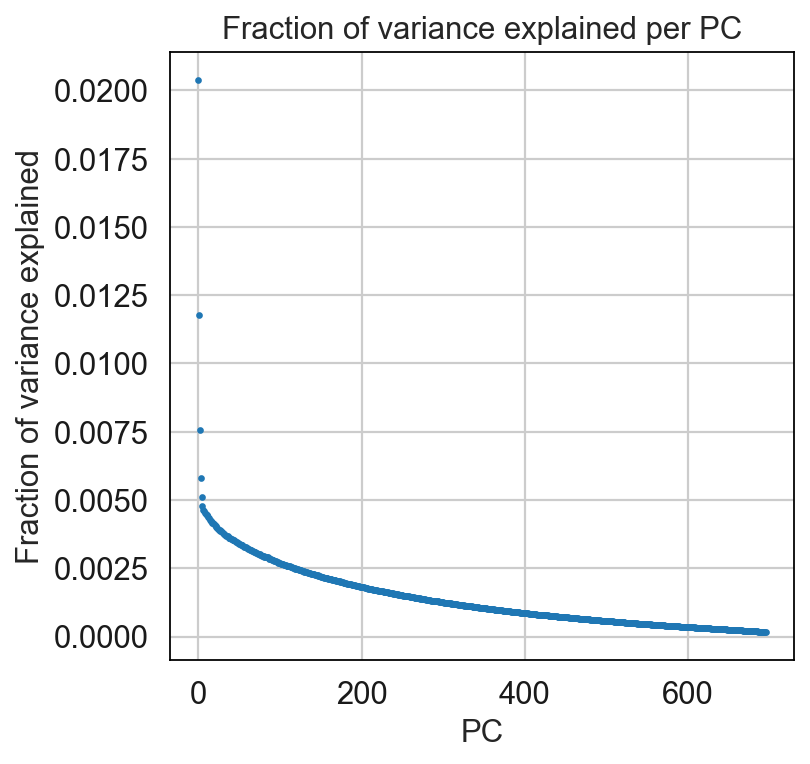

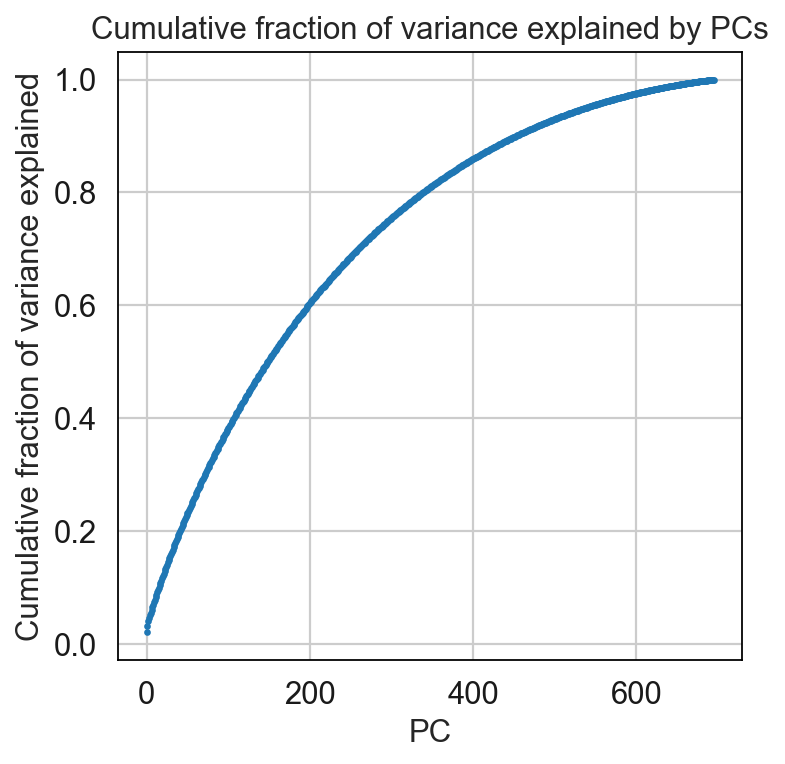

Knee point: 24
Explained variance: 0.1364473


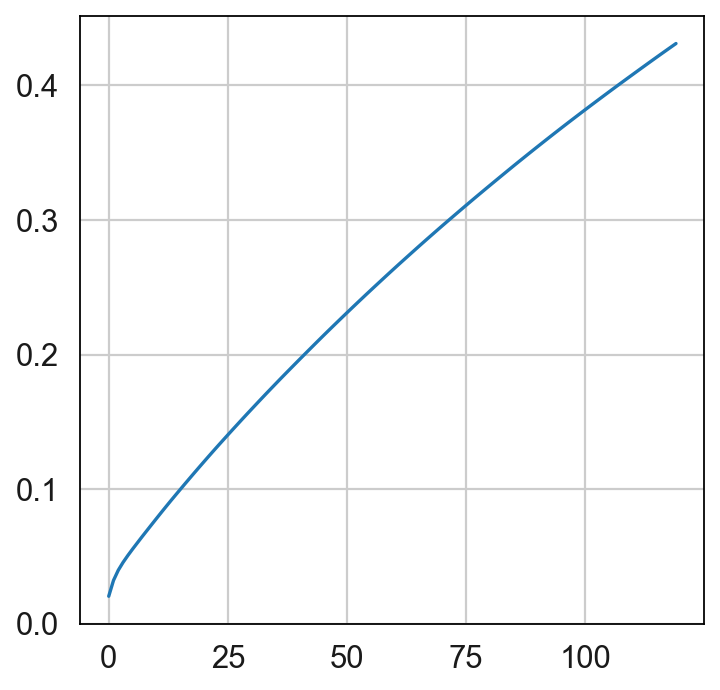

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


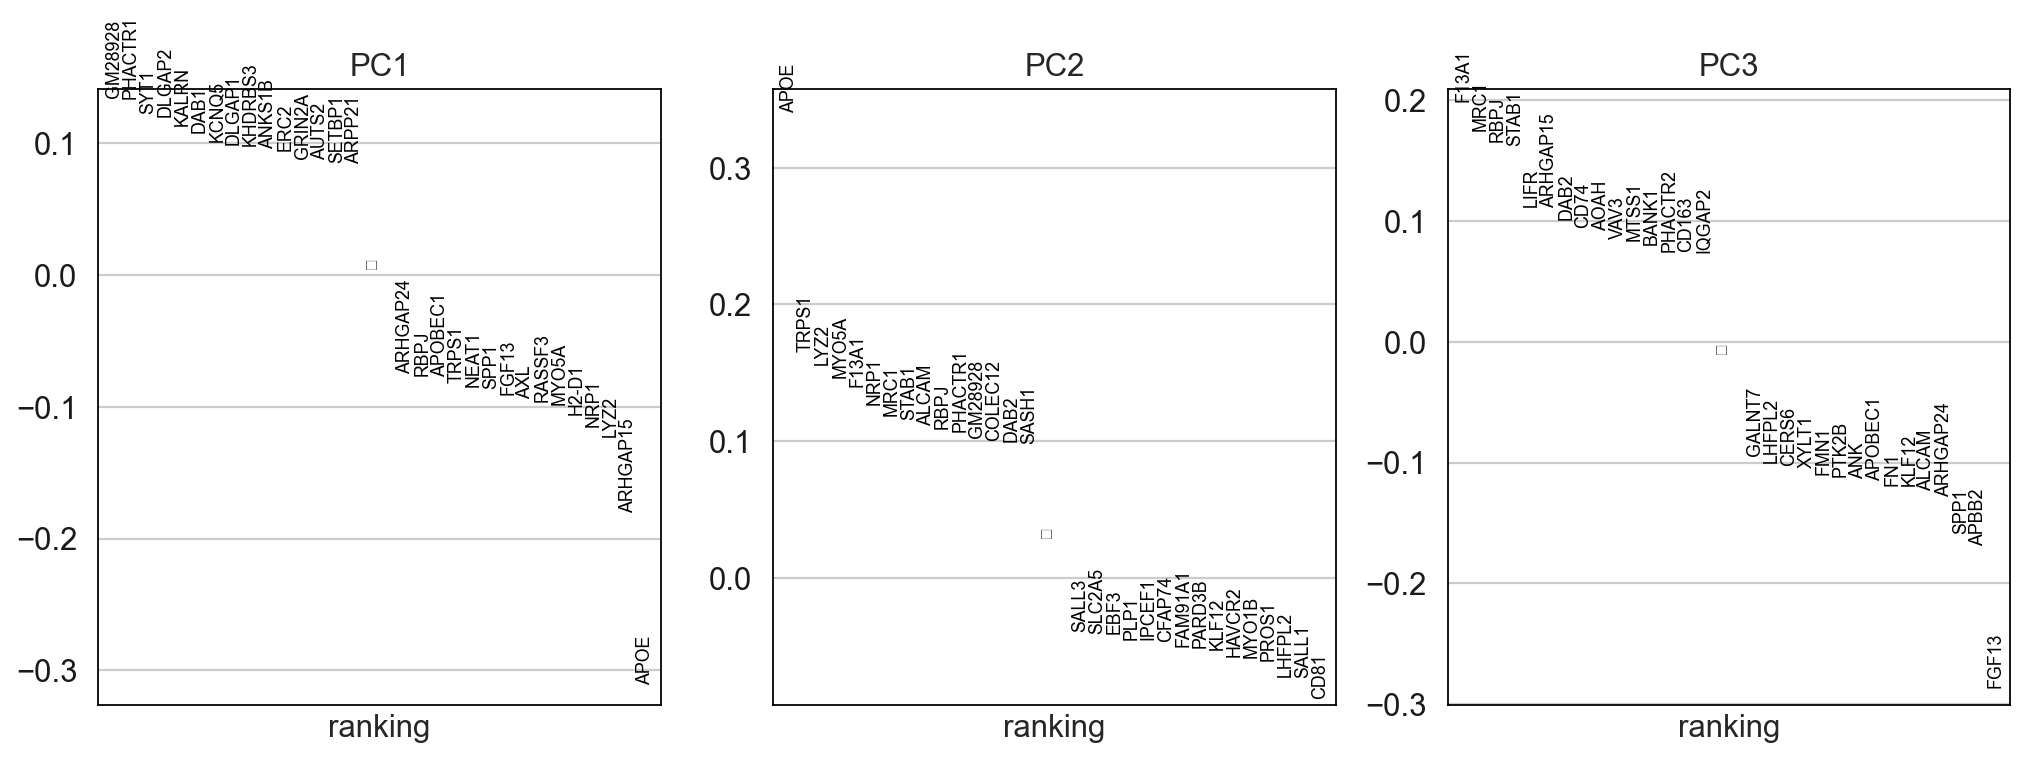

(697, 9799)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [21]:
sc.set_figure_params(figsize=(5, 5))
adata_microglia = run_pca_knee(adata_microglia)#, 0.5)
adata_microglia.obs['PC 1'] = adata_microglia.obsm['X_pca'][:,0] # optional
adata_microglia.obs['PC 2'] = adata_microglia.obsm['X_pca'][:,1]
adata_microglia.obs['PC 3'] = adata_microglia.obsm['X_pca'][:,2]

print(adata_microglia.shape)
adata_microglia.X = pd.DataFrame(adata_microglia.X).fillna(0).values
index_list = np.arange(adata_microglia.shape[0])
np.random.shuffle(index_list)
adata_microglia = adata_microglia[index_list,:]

In [22]:
print(adata_microglia.shape)
adata_microglia.X = pd.DataFrame(adata_microglia.X).fillna(0).values
index_list = np.arange(adata_microglia.shape[0])
np.random.shuffle(index_list)
adata_microglia = adata_microglia[index_list,:]

(697, 9799)


## Phenograph

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.10524702072143555 seconds
Jaccard graph constructed in 2.7621102333068848 seconds
Wrote graph to binary file in 0.016152620315551758 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.665928
After 6 runs, maximum modularity is Q = 0.669088
After 18 runs, maximum modularity is Q = 0.672115
Louvain completed 38 runs in 0.6485161781311035 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 4.218059062957764 seconds


Trying to set attribute `.obs` of view, copying.


Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.015410900115966797 seconds
Jaccard graph constructed in 0.8144750595092773 seconds
Wrote graph to binary file in 0.015258312225341797 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.623683
After 2 runs, maximum modularity is Q = 0.625445
After 11 runs, maximum modularity is Q = 0.628913
Louvain completed 31 runs in 0.519085168838501 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 2.081122875213623 seconds
Finding 20 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.015459299087524414 seconds
Jaccard graph constructed in 0.817255973815918 seconds
Wrote graph to binary file in 0.10108399391174316 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.594423
After 2 runs, maximum modularity is Q = 0.602408
After 6 runs, maximum modularity is Q = 0.604369


Text(0.5, 0, 'k')

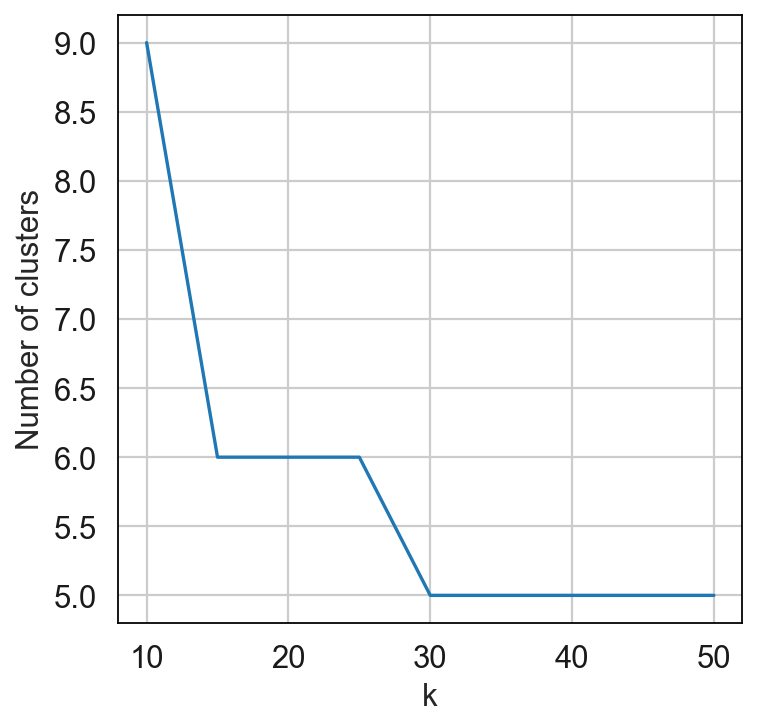

In [23]:
k_list = list(range(10, 55, 5))
n_clusters = []
for k in k_list:
    communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata_microglia.obsm['X_pca']),k=k)
    n_clusters.append(len(np.unique(communities)))
    adata_microglia.obs['PhenoGraph_clusters_mic'+str(k)] = pd.Categorical(communities)
    adata_microglia.uns['PhenoGraph_Q_'+str(k)] = Q
    adata_microglia.uns['PhenoGraph_k_'+str(k)] = k
plt.plot(k_list,n_clusters)
plt.ylabel("Number of clusters")
plt.xlabel("k")

In [24]:
Rand_index_df = pd.DataFrame(np.zeros((len(k_list), len(k_list))),index=k_list,columns=k_list)
Rand_index_df.index.name='k1'
Rand_index_df.columns.name='k2'
row_ind = 0
for run1 in range(len(k_list)):
    col_ind = 0
    for run2 in range(len(k_list)):
        Rand_index_df.iloc[row_ind,col_ind] = adjusted_rand_score(
            adata_microglia.obs['PhenoGraph_clusters_mic'+str(k_list[run1])].values,
            adata_microglia.obs['PhenoGraph_clusters_mic'+str(k_list[run2])].values)
        col_ind = col_ind+1
    row_ind = row_ind+1
    

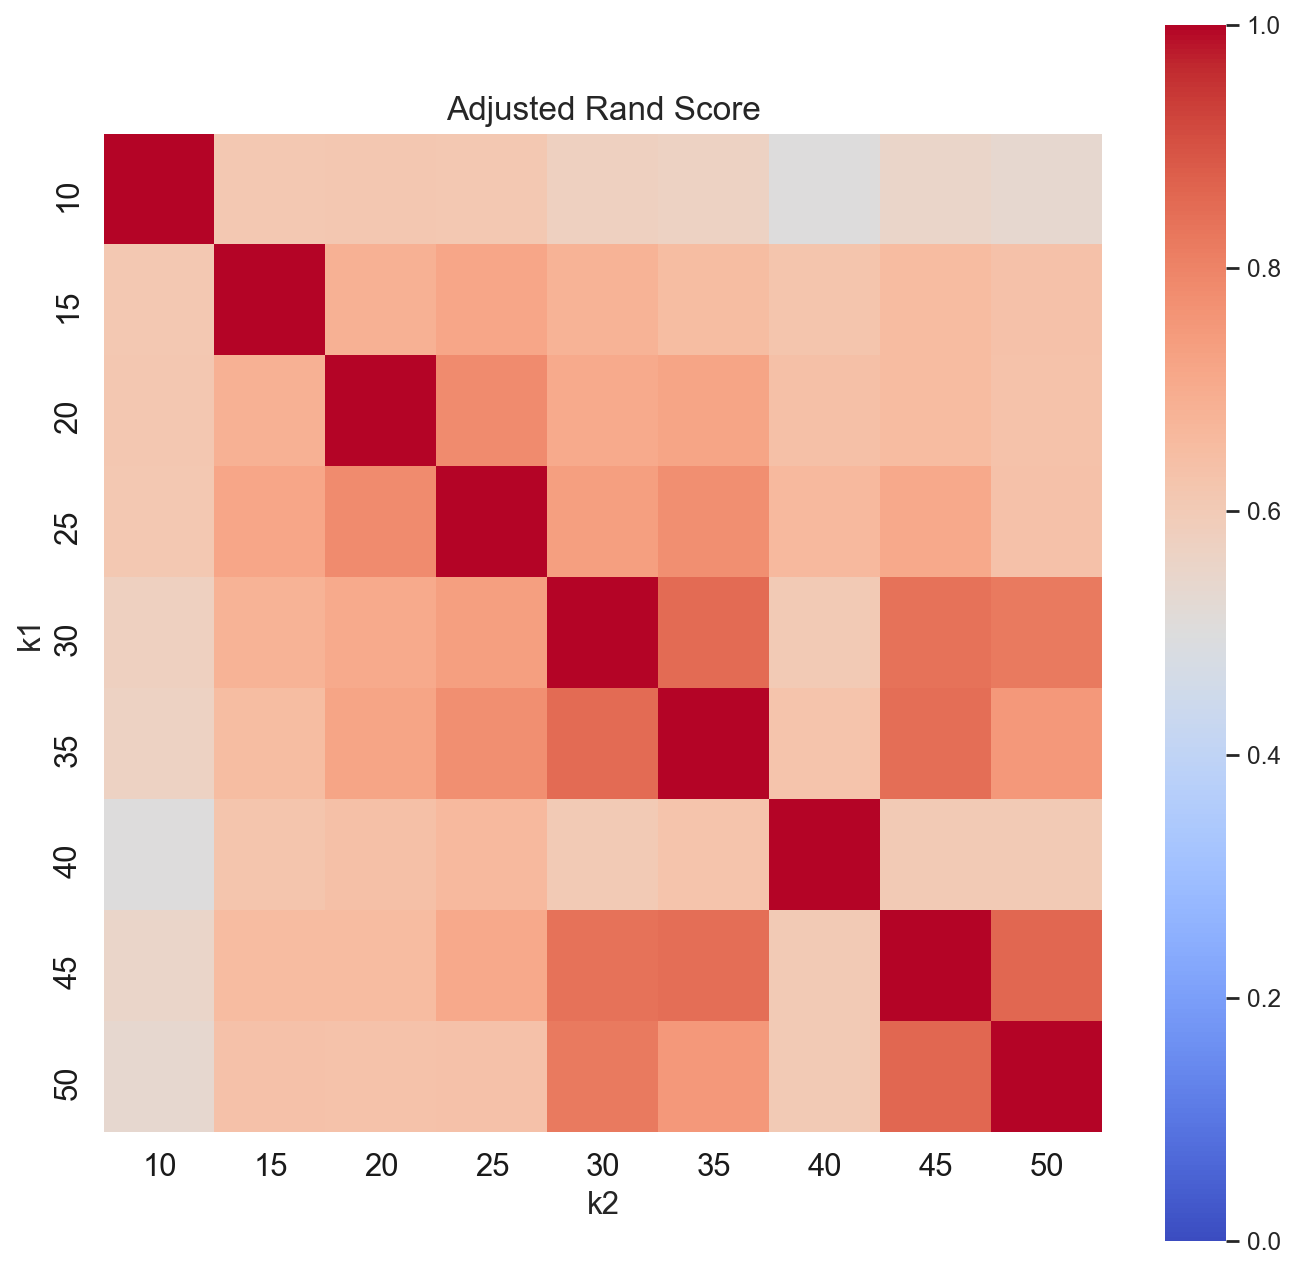

In [25]:
Rand_fig = plt.figure(figsize = (10,10))
plt.xlabel('k1')
plt.ylabel('k2')
plt.title('Adjusted Rand Score',fontsize=15)
sns.set(font_scale=1)
sns.heatmap(Rand_index_df, cmap=('coolwarm'), square=True, vmin=0, vmax=1)
# plt.colorbar(vmin=0)
plt.show();plt.close()


In [29]:
k = 45 # choose k
communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata_microglia.obsm['X_pca']),k=k) # run PhenoGraph
adata_microglia.obs['PhenoGraph_clusters_mic'] = pd.Categorical(communities)
adata_microglia.uns['PhenoGraph_Q'] = Q
adata_microglia.uns['PhenoGraph_k'] = k

Finding 45 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.016889095306396484 seconds
Jaccard graph constructed in 0.910722017288208 seconds
Wrote graph to binary file in 0.05154109001159668 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.484386
After 2 runs, maximum modularity is Q = 0.492714
After 4 runs, maximum modularity is Q = 0.495008
Louvain completed 24 runs in 0.5084371566772461 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 2.1930270195007324 seconds


## Vizualize Microglia sub-clusters

In [30]:
sc.pp.neighbors(adata_microglia, method='umap', use_rep='X_pca')
sc.tl.umap(adata_microglia, random_state=None)

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


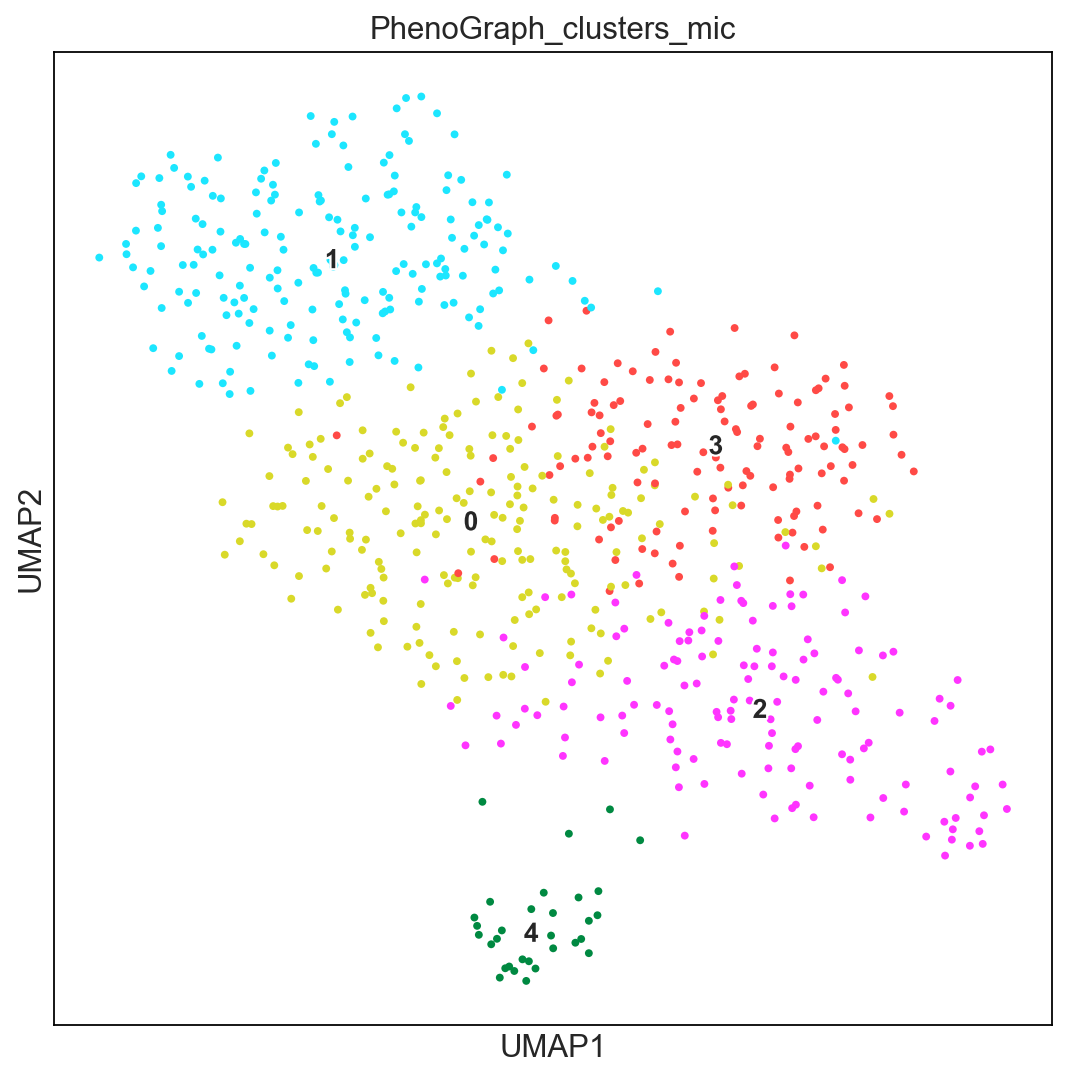

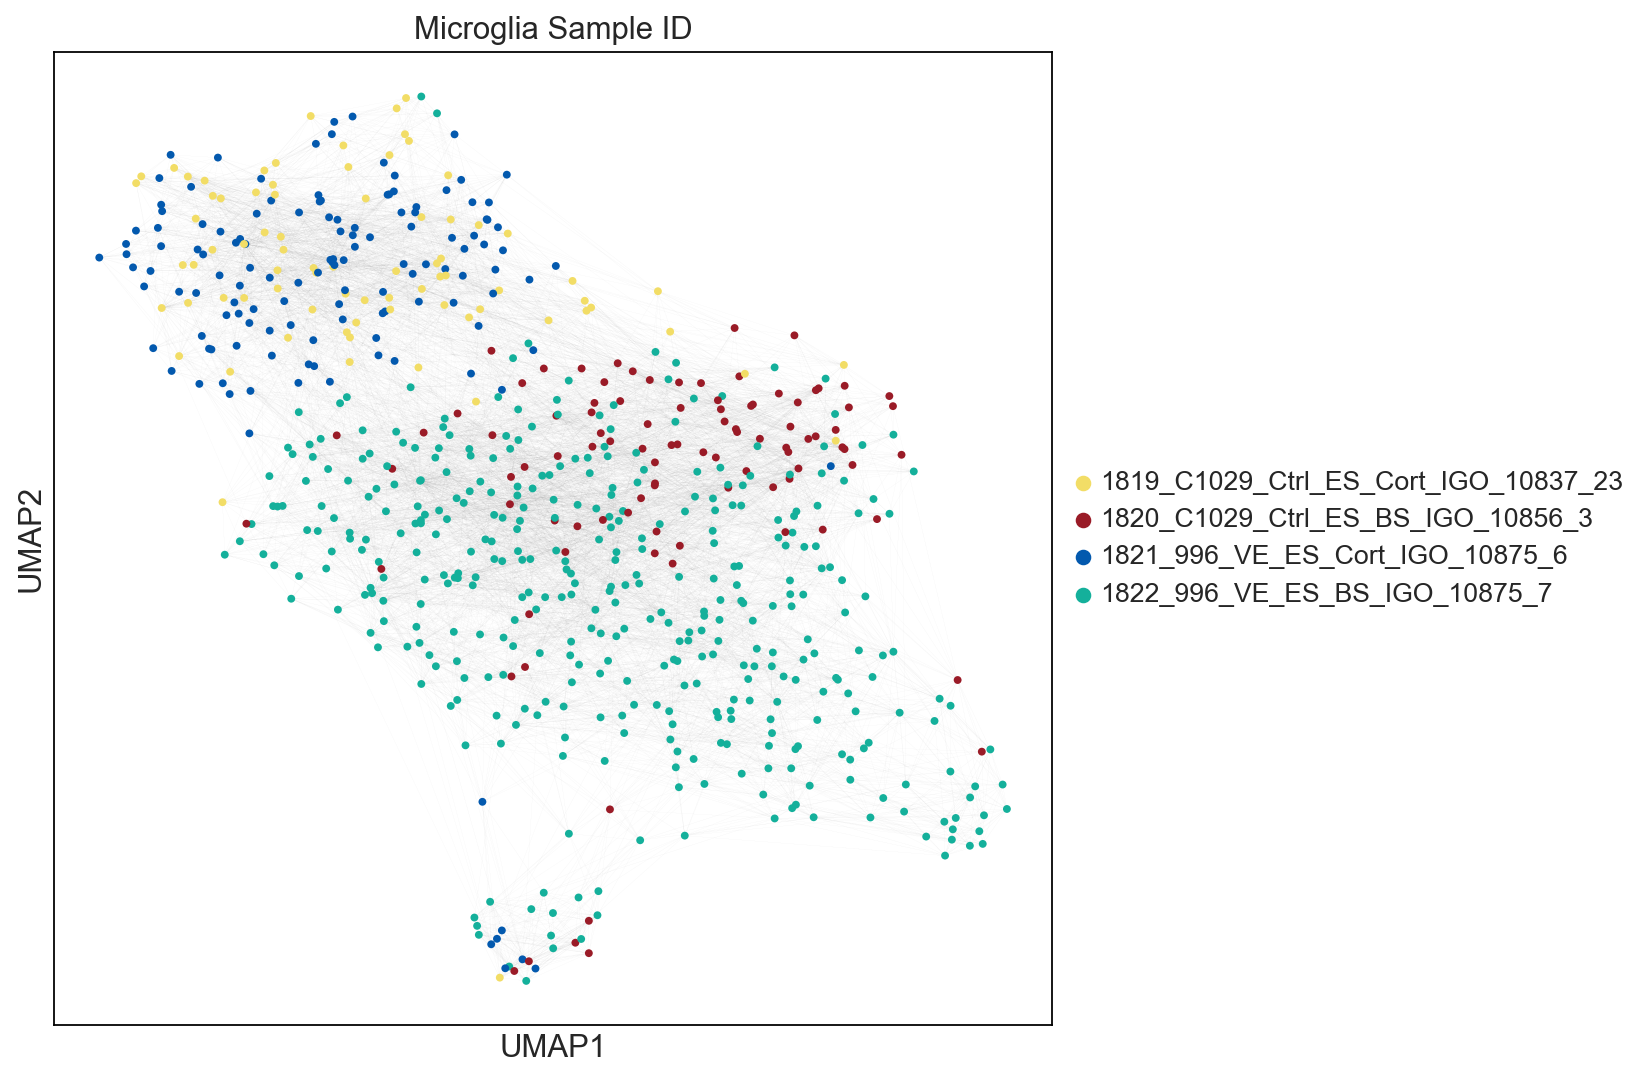

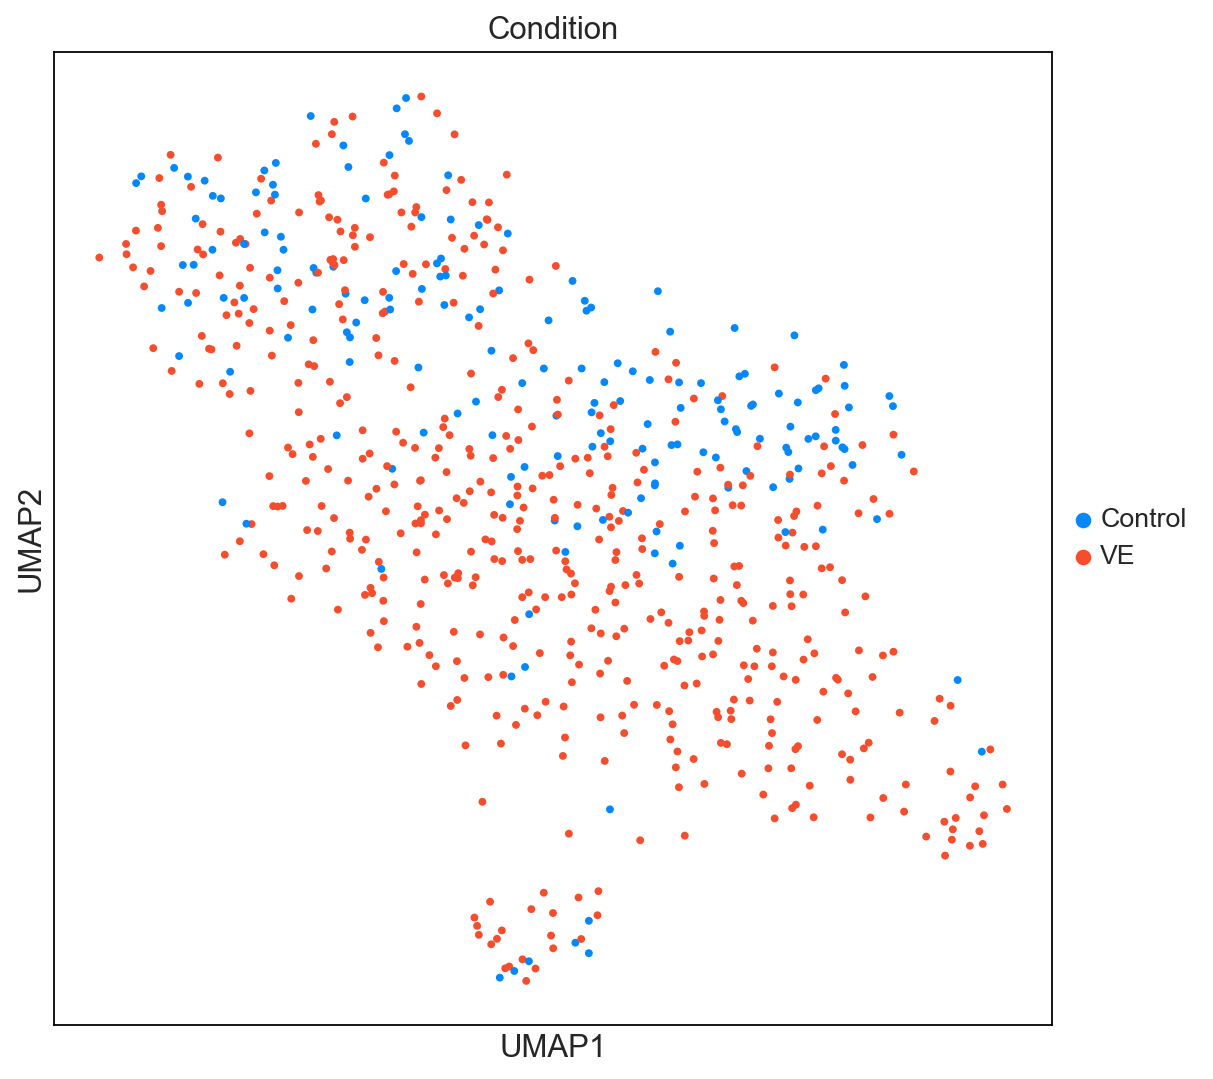

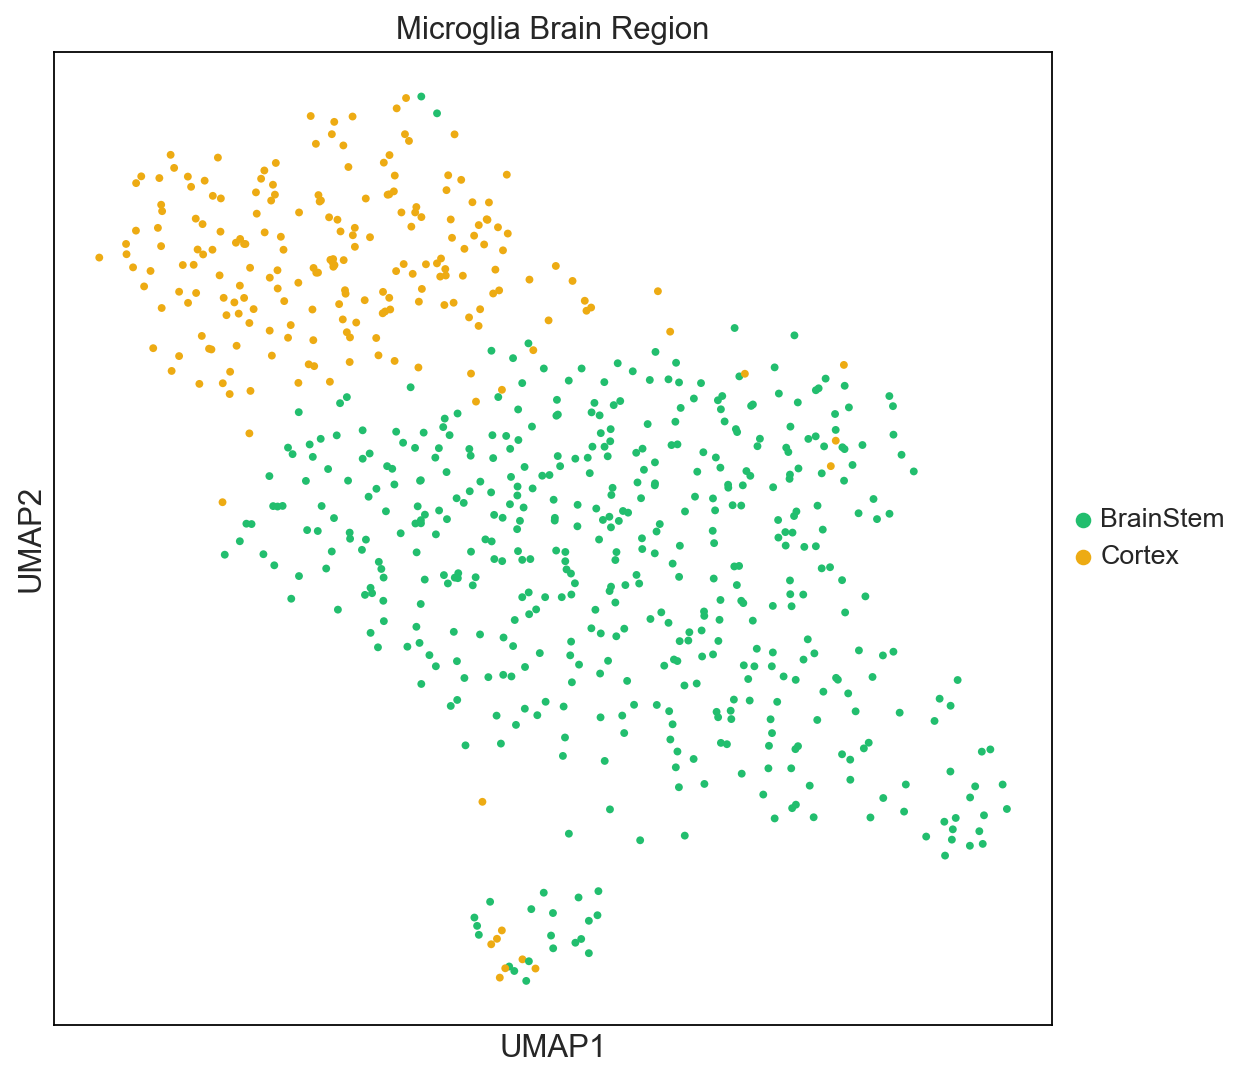

In [31]:
sc.set_figure_params(figsize=(8, 8))

adata_microglia_VE = adata_microglia.copy()
adata_microglia_VE = adata_microglia_VE[adata_microglia_VE.obs.Condition == 'VE']

adata_microglia_WT = adata_microglia.copy()
adata_microglia_WT = adata_microglia_WT[adata_microglia_WT.obs.Condition == 'Control']


sc.pl.umap(
    adata_microglia,
    color=['PhenoGraph_clusters_mic'],
    ncols=2,
    sort_order=False,
    #edges = True,
    palette=godsnot_64, # 'palette' specifies the colormap to use
    cmap='Spectral_r',
    legend_loc='on data',
    legend_fontsize=12, size = 50,
    legend_fontoutline=2,
    #save= '_immune_cells_PhenoGraph_clusters'
)

sc.pl.umap(adata_microglia, 
           color= ['Sample ID'],
           ncols=2,
           edges = True,
           edges_width= 0.01,
           palette= ["#F2DD66", "#9A1B27", "#0359AE", "#14B09B"],
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Microglia Sample ID"])

sc.pl.umap(adata_microglia,
           color=['Condition'],
           ncols=2,
           sort_order=False,
           palette=['#0488FC','#F64E2C'], # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_fontsize=12, size = 50, frameon = True,
           legend_fontoutline=2)

sc.pl.umap(adata_microglia, 
           color= ['B_region'],
           ncols=2,
           palette= ["#22BE6E", "#EDAB13"],
           size=50, 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Microglia Brain Region"])


## Find markers (Microglia clusters)

In [32]:
cl_int_to_str = dict()
cl_int_to_str = {
    0 : 'Mic0',
    1 : 'Mic1',
    2 : 'Mic2',
    3 : 'Mic3',
    4 : 'Mic4',}

adata_microglia.obs['PhenoGraph_clusters_mic_str'] = adata_microglia.obs['PhenoGraph_clusters_mic'].map(cl_int_to_str).astype('category')

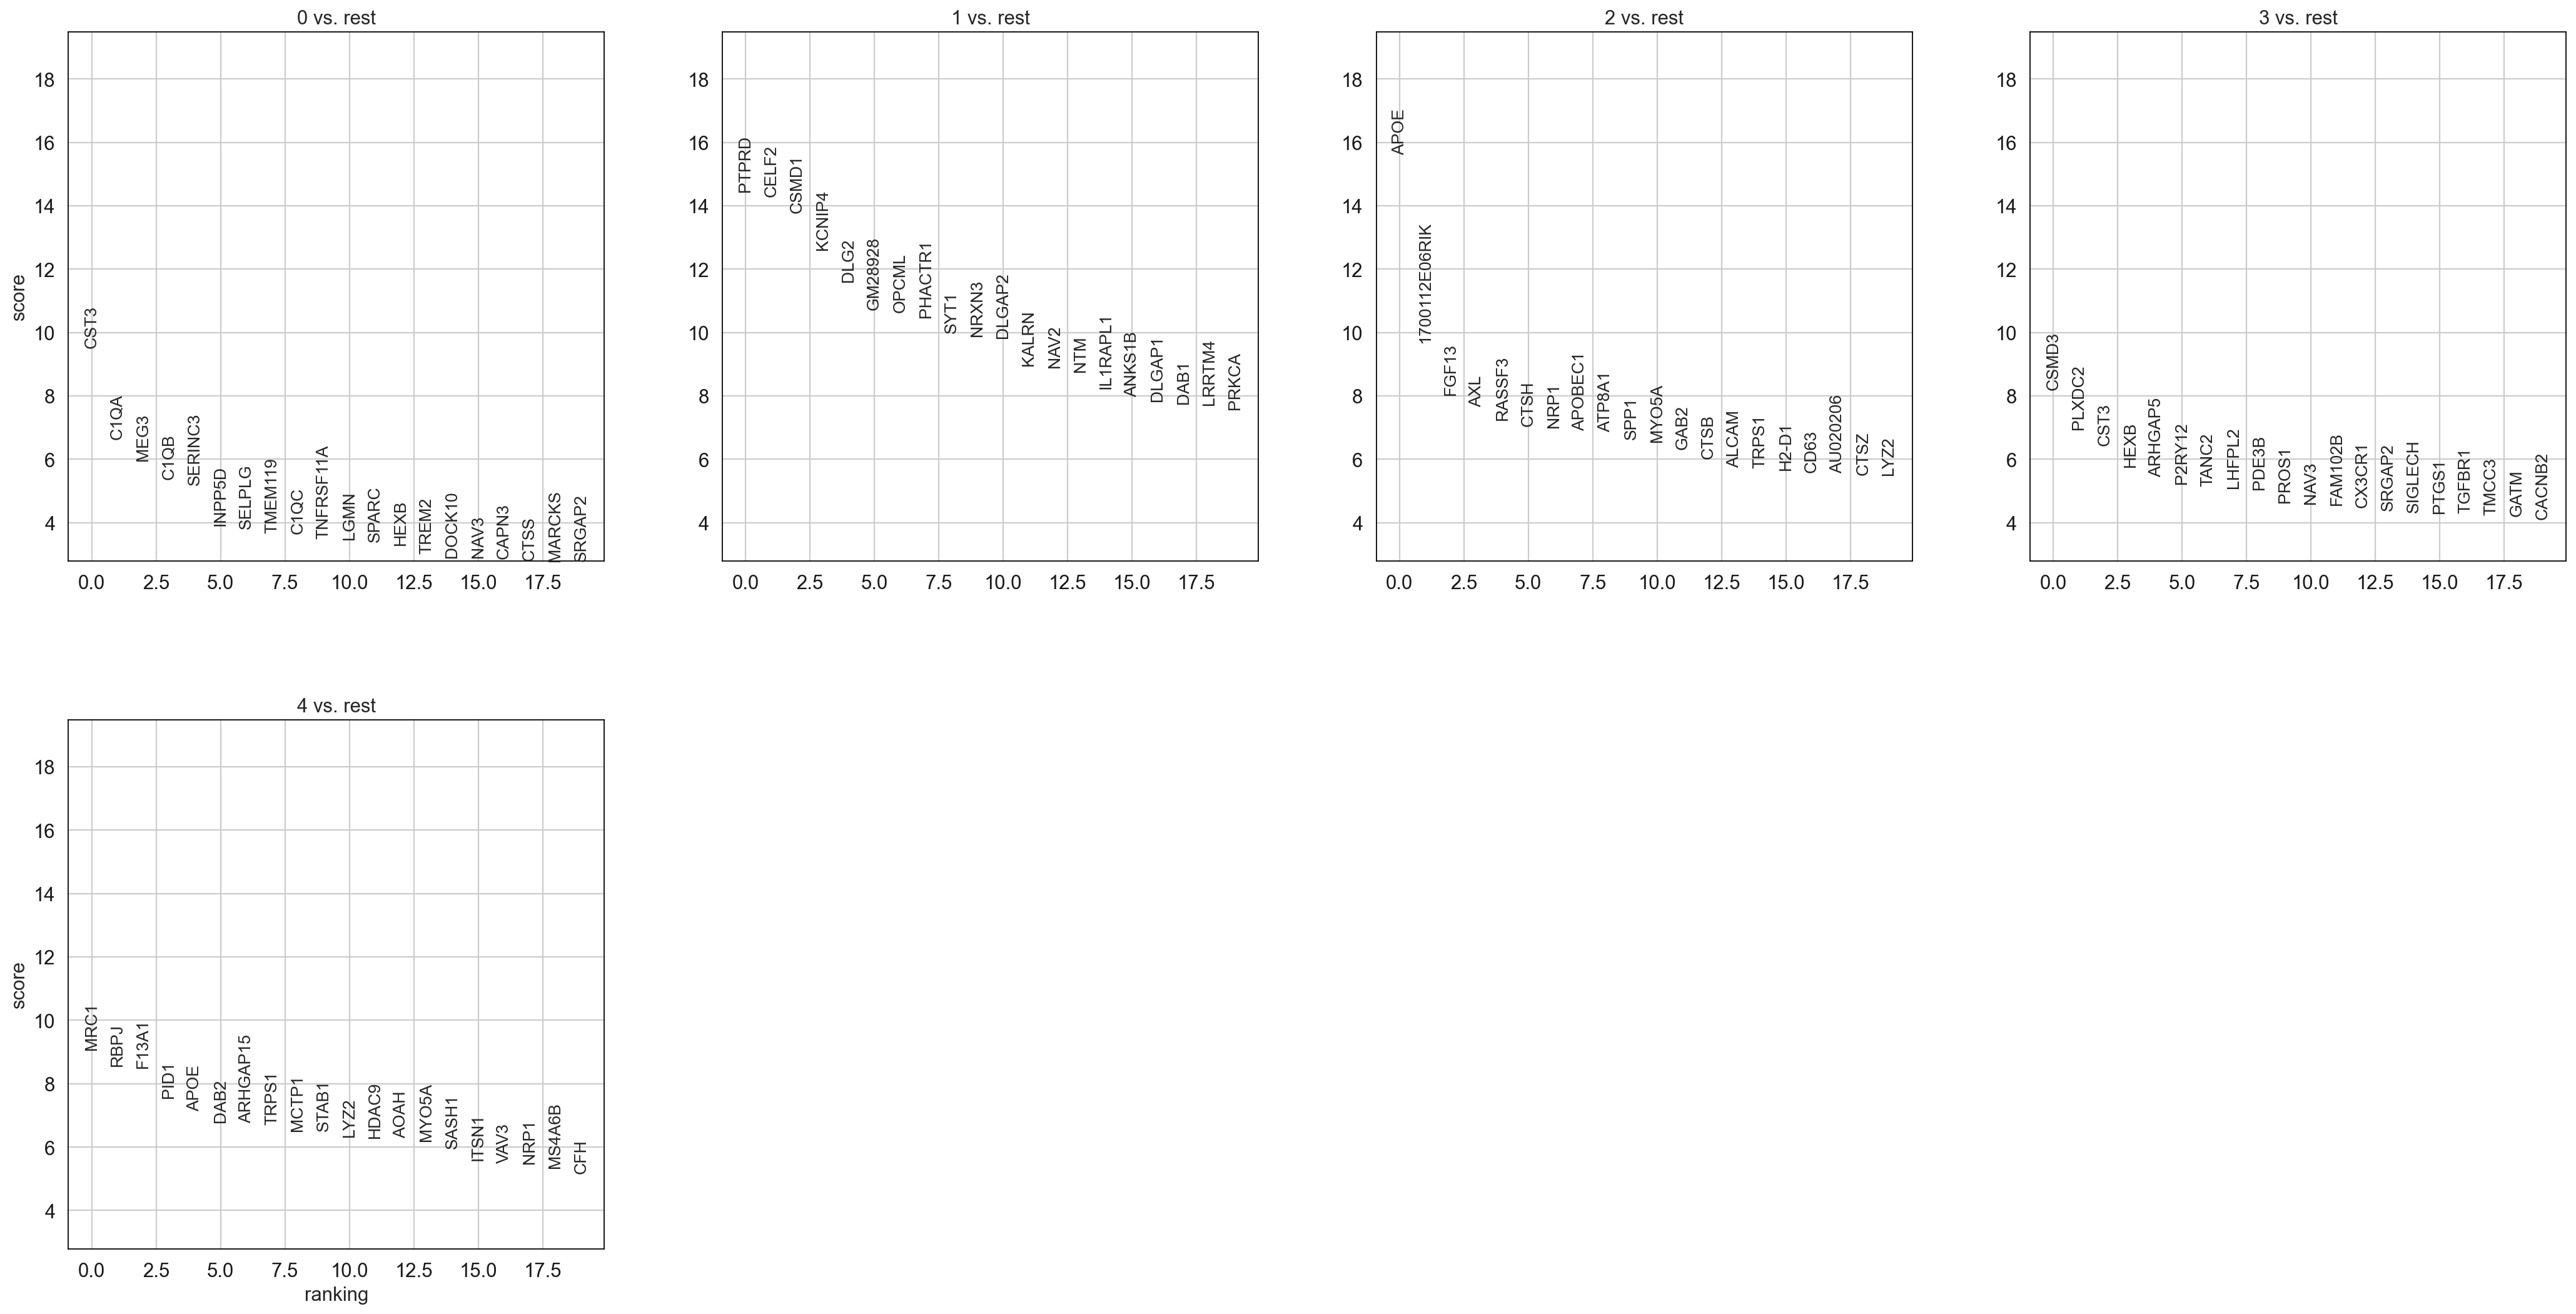

In [33]:
sc.tl.rank_genes_groups(adata_microglia, groupby='PhenoGraph_clusters_mic', key_added="ranked_genes_pheno_mic", method='wilcoxon')
sc.pl.rank_genes_groups(adata_microglia, key = 'ranked_genes_pheno_mic', fontsize=12)

## Visualize marker genes using heatmap

In [34]:
adata_microglia.layers['scaled'] = sc.pp.scale(adata_microglia, copy=True).X

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


{'heatmap_ax': <AxesSubplot:>,
 'groupby_ax': <AxesSubplot:xlabel='PhenoGraph_clusters_mic_str'>,
 'dendrogram_ax': <AxesSubplot:>,
 'gene_groups_ax': <AxesSubplot:>}

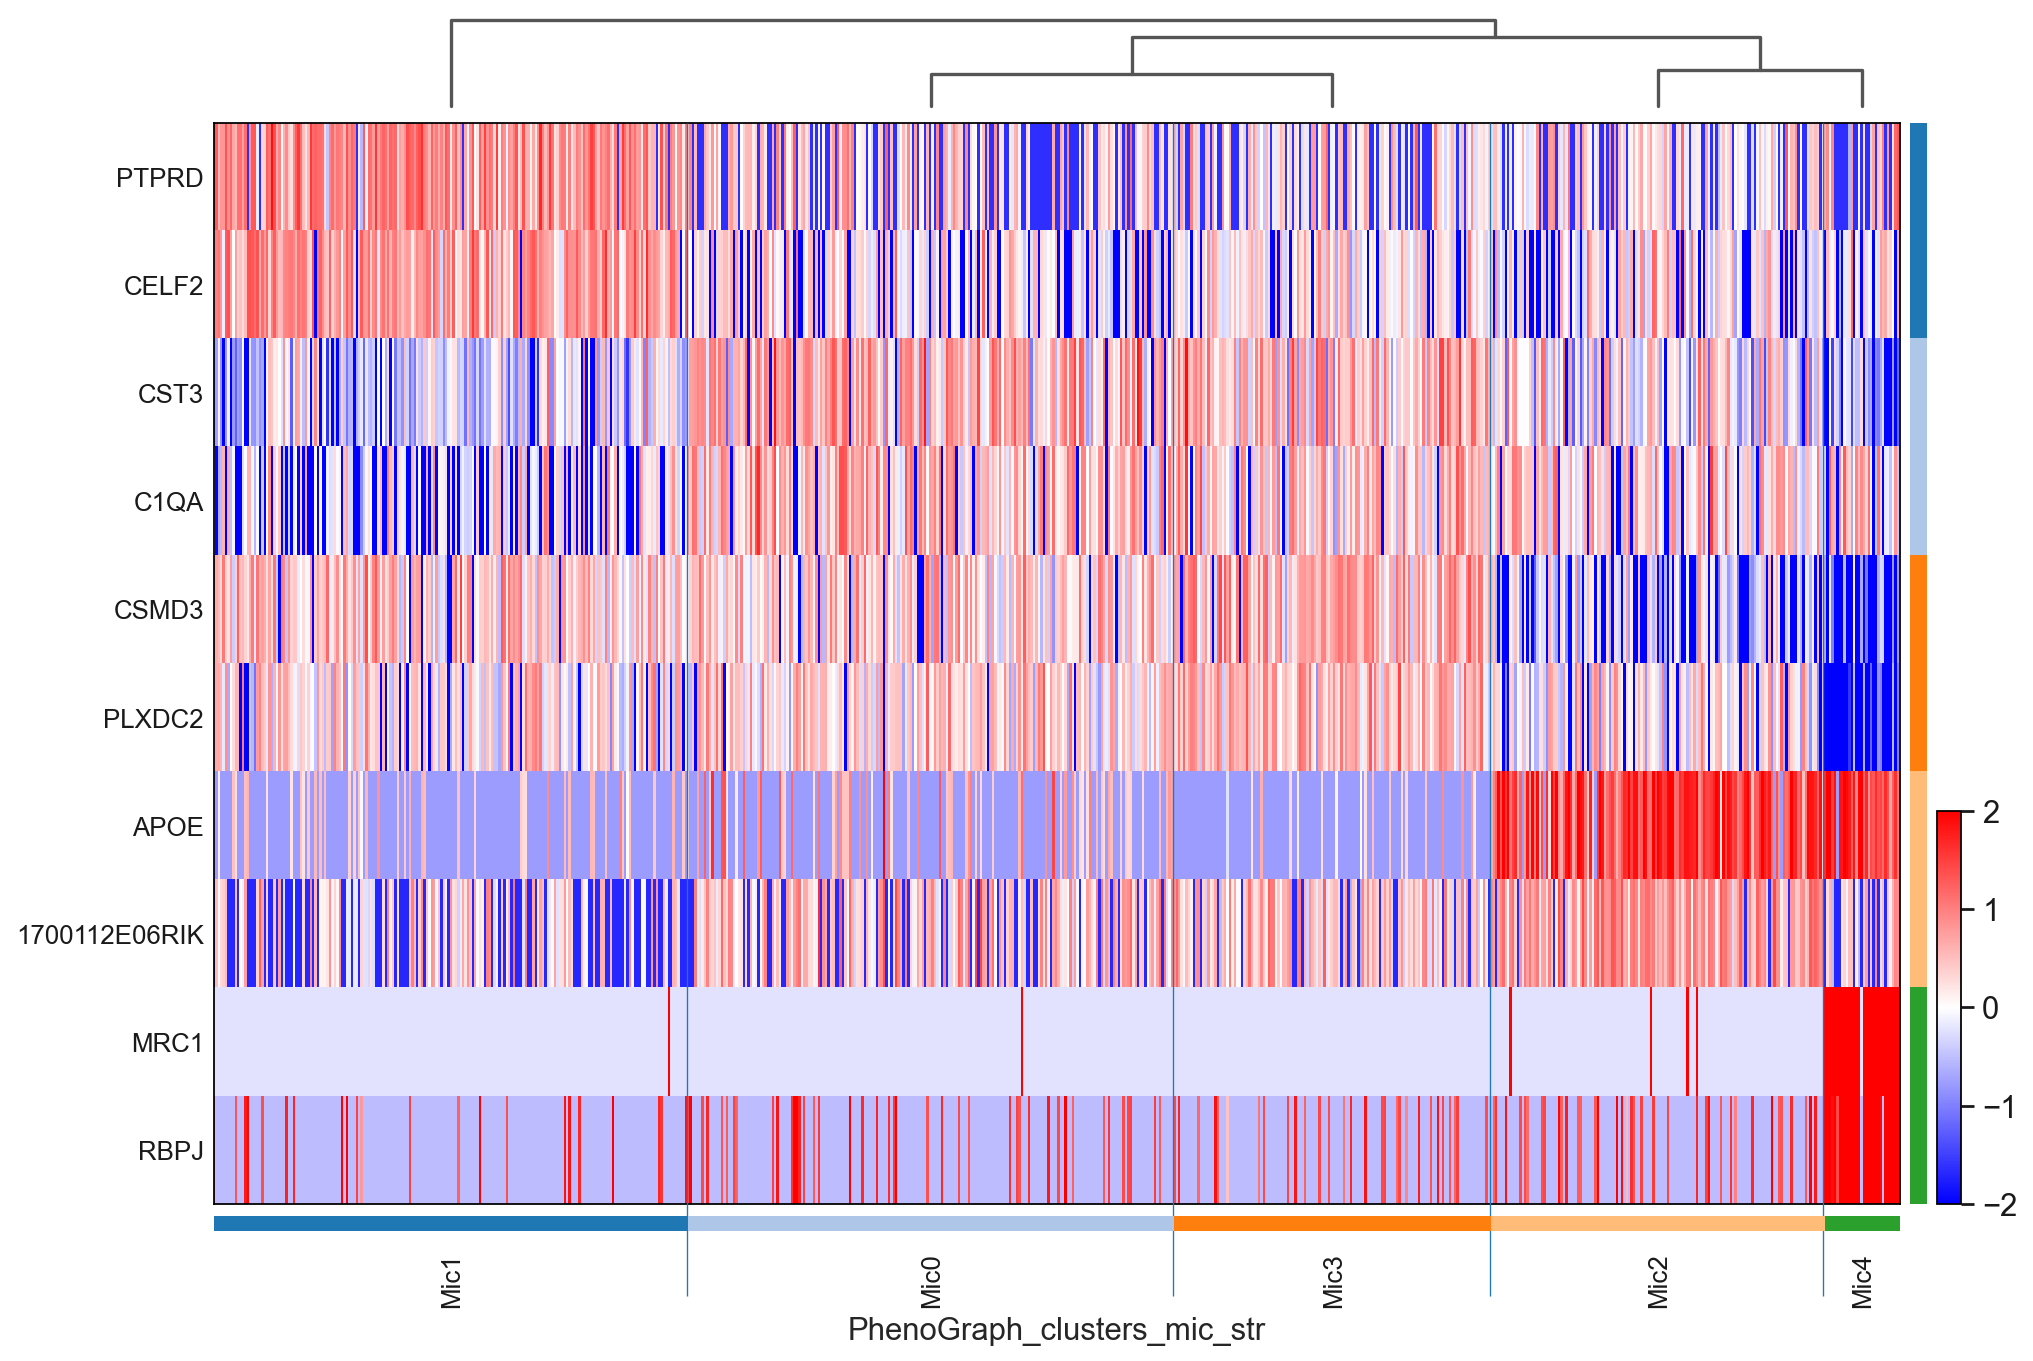

In [35]:
sc.tl.rank_genes_groups(adata_microglia, groupby='PhenoGraph_clusters_mic_str', n_genes=adata_microglia.shape[1], method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata_microglia, n_genes=2, use_raw=False, swap_axes=True, vmin=-2, vmax=2, cmap='bwr', layer='scaled', figsize=(14,10), show=False)

In [36]:
adata_microglia.obs['PhenoGraph_clusters_mic_str'].value_counts()

Mic0    201
Mic1    196
Mic2    138
Mic3    131
Mic4     31
Name: PhenoGraph_clusters_mic_str, dtype: int64

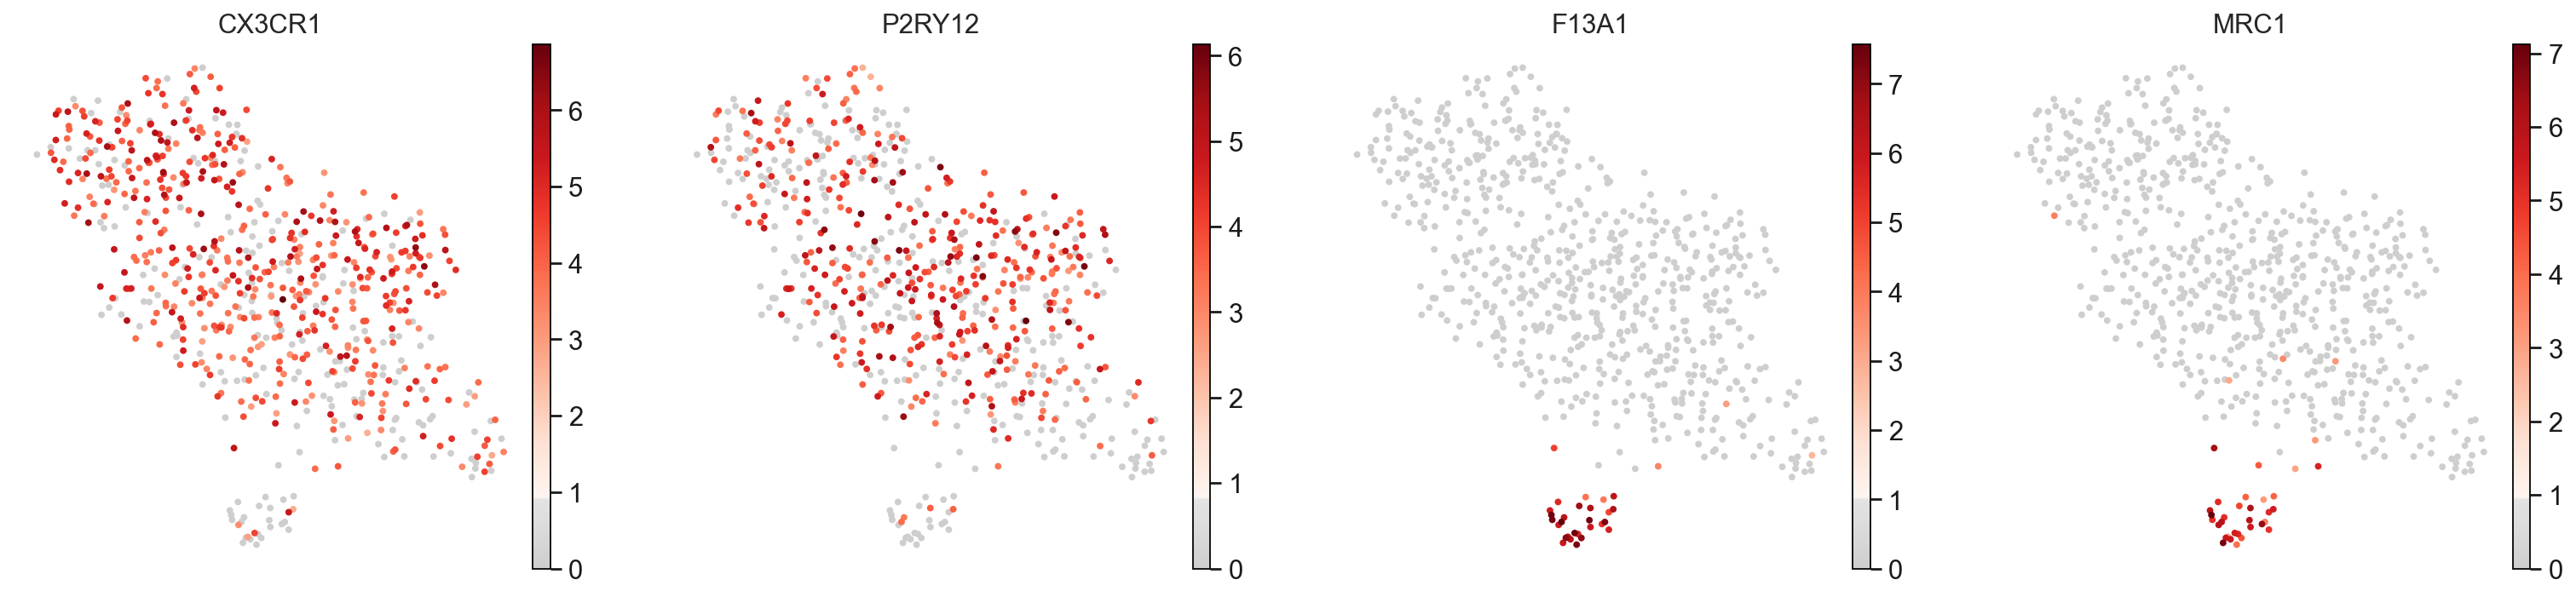

In [32]:
sc.set_figure_params(figsize=(5, 5))
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
 
sc.pl.umap(adata_microglia,
           size = 50,
           color=['CX3CR1','P2RY12','F13A1', 'MRC1'],
           color_map=mymap,
          frameon=False)


## F13A1 cluster

In [36]:
F13A1_genes_dict = dict()

F13A1_genes_dict = {'F13A1_genes':['MRC1', 'F13A1', 'RBPJ', 'PID1', 'APOE', 'STAB1']}


In [ ]:
sc.set_figure_params(figsize=(5, 5))
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
 
sc.pl.umap(adata_microglia,
           size = 50,
           color=F13A1_genes_dict['F13A1_genes'],
           color_map=mymap,
          frameon=False)


## Save result Adata Microglia

In [43]:
#adata_microglia.write_h5ad(outdir+'adata_high_var_Microglia_clusters.h5ad')

... storing 'microglia_subclusters' as categorical


In [24]:
adata_microglia = sc.read_h5ad(outdir+'adata_high_var_Microglia_clusters.h5ad')

## Reclustering of Microglia cells

Load the adata object that holds the latest cell type annotations..

Locate the indeces that correcpond to Mic5 or the rest, and assign a new label to the new column **microglia_subclusters**

In [12]:
adata_microglia.obs.loc[adata_microglia.obs['PhenoGraph_clusters_mic_str'] == 'Mic4', 'microglia_subclusters'] = 'F13A1_cluster'
adata_microglia.obs.loc[adata_microglia.obs['PhenoGraph_clusters_mic_str'] != 'Mic4', 'microglia_subclusters'] = 'Microglia'

In [13]:
adata_microglia_only = deepcopy(adata_microglia)
adata_microglia_only = adata_microglia[adata_microglia.obs['microglia_subclusters'].isin(['Microglia']),:]
adata_microglia_only.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(666, 9799)

In [17]:
adata_microglia_only = adata[adata_microglia_only.obs.index, :]
adata_microglia_only.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(666, 22292)

### QC

In [18]:
adata_microglia_only, mito_genes, RB_genes_in_data = qc_metrics(adata_microglia_only)
markers = []
if type(adata_microglia_only.X)==np.ndarray:
    pass
else:
    print(type(adata_microglia_only.X))
    #print(adata_norm.X.shape)
    adata_microglia_only.X = adata_microglia_only.X.toarray()
    #print(adata_norm.X.shape)
adata_microglia_only.X = pd.DataFrame(data=adata_microglia_only.X).fillna(0).values

Trying to set attribute `.var` of view, copying.


QC metrics calculated.
<class 'scipy.sparse.csr.csr_matrix'>


In [19]:
adata_microglia_only.shape

(666, 22292)

### Normalization

In [20]:
markers = []
adata_microglia_only, markers = norm_filter(adata_microglia_only, mito_genes, RB_genes_in_data, markers=[], highly_var=True)
adata_microglia_only.obs.head()

(666, 22292)
(666, 9797)
(666, 9655)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(666, 9644)
True
Im here2


Trying to set attribute `.uns` of view, copying.


2000
2000


Sample ID  \
cell_barcodes                                                                              
200967504653171_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
192306956586398_1822_996_VE_ES_BS_IGO_10875_7              1822_996_VE_ES_BS_IGO_10875_7   
227905792534302_1822_996_VE_ES_BS_IGO_10875_7              1822_996_VE_ES_BS_IGO_10875_7   
122307606918886_1820_C1029_Ctrl_ES_BS_IGO_10856_3      1820_C1029_Ctrl_ES_BS_IGO_10856_3   
232328294456619_1821_996_VE_ES_Cort_IGO_10875_6          1821_996_VE_ES_Cort_IGO_10875_6   

                                                   Condition   B_region  \
cell_barcodes                                                             
200967504653171_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control     Cortex   
192306956586398_1822_996_VE_ES_BS_IGO_10875_7             VE  BrainStem   
227905792534302_1822_996_VE_ES_BS_IGO_10875_7             VE  BrainStem   
122307606918886_1820_C1029_Ctrl_ES_BS_IGO_10856_3    Control  BrainStem   
232328294456619_1821_996_VE_ES_Cort_IGO_10875_6           VE     Cortex   

                                                    n_genes_by_counts  \
cell_barcodes                                                           
200967504653171_1819_C1029_Ctrl_ES_Cort_IGO_108...               1146   
192306956586398_1822_996_VE_ES_BS_IGO_10875_7                     612   
227905792534302_1822_996_VE_ES_BS_IGO_10875_7                    1118   
122307606918886_1820_C1029_Ctrl_ES_BS_IGO_10856_3                1511   
232328294456619_1821_996_VE_ES_Cort_IGO_10875_6                   627   

                                                    log1p_n_genes_by_counts  \
cell_barcodes                                                                 
200967504653171_1819_C1029_Ctrl_ES_Cort_IGO_108...                 7.044905   
192306956586398_1822_996_VE_ES_BS_IGO_10875_7                      6.418365   
227905792534302_1822_996_VE_ES_BS_IGO_10875_7                      7.020191   
122307606918886_1820_C1029_Ctrl_ES_BS_IGO_10856_3                  7.321189   
232328294456619_1821_996_VE_ES_Cort_IGO_10875_6                    6.442540   

                                                    total_counts  \
cell_barcodes                                                      
200967504653171_1819_C1029_Ctrl_ES_Cort_IGO_108...        1758.0   
192306956586398_1822_996_VE_ES_BS_IGO_10875_7              803.0   
227905792534302_1822_996_VE_ES_BS_IGO_10875_7             1598.0   
122307606918886_1820_C1029_Ctrl_ES_BS_IGO_10856_3         2408.0   
232328294456619_1821_996_VE_ES_Cort_IGO_10875_6            773.0   

                                                    log1p_total_counts  \
cell_barcodes                                                            
200967504653171_1819_C1029_Ctrl_ES_Cort_IGO_108...            7.472501   
192306956586398_1822_996_VE_ES_BS_IGO_10875_7                 6.689599   
227905792534302_1822_996_VE_ES_BS_IGO_10875_7                 7.377134   
122307606918886_1820_C1029_Ctrl_ES_BS_IGO_10856_3             7.786967   
232328294456619_1821_996_VE_ES_Cort_IGO_10875_6               6.651572   

                                                    pct_counts_in_top_50_genes  \
cell_barcodes                                                                    
200967504653171_1819_C1029_Ctrl_ES_Cort_IGO_108...                   17.974972   
192306956586398_1822_996_VE_ES_BS_IGO_10875_7                        25.653798   
227905792534302_1822_996_VE_ES_BS_IGO_10875_7                        17.521902   
122307606918886_1820_C1029_Ctrl_ES_BS_IGO_10856_3                    17.857143   
232328294456619_1821_996_VE_ES_Cort_IGO_10875_6                      19.663648   

                                                    pct_counts_in_top_100_genes  \
cell_barcodes                                                                     
200967504653171_1819_C1029_Ctrl_ES_Cort_IGO_108...                    27.417520   
192306956586398_1822_9

### PCA

[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        4.3090057 0.        ... 0.        4.3090057 0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]
(666, 9644)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(666, 9644)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


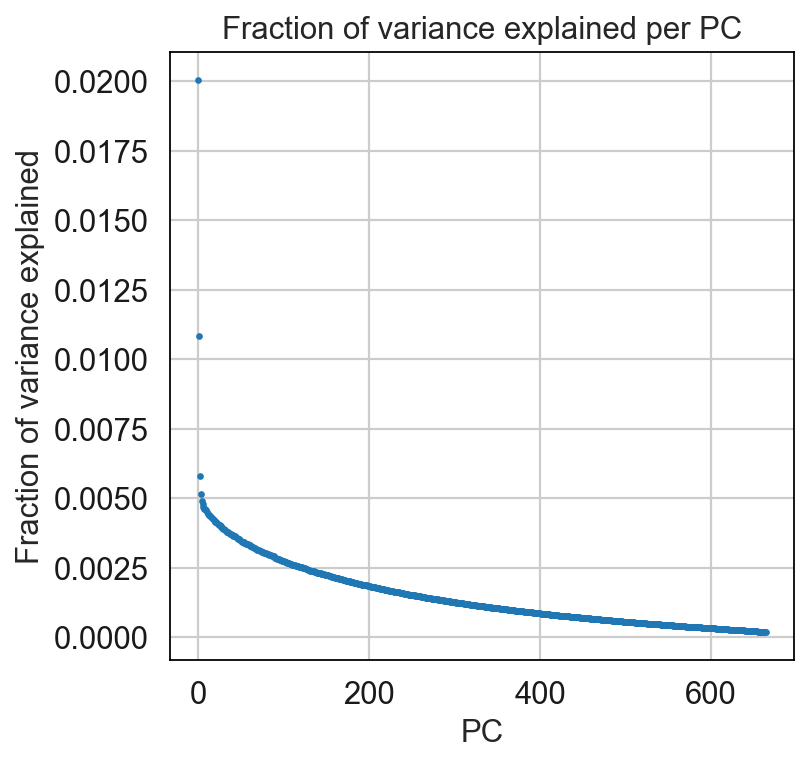

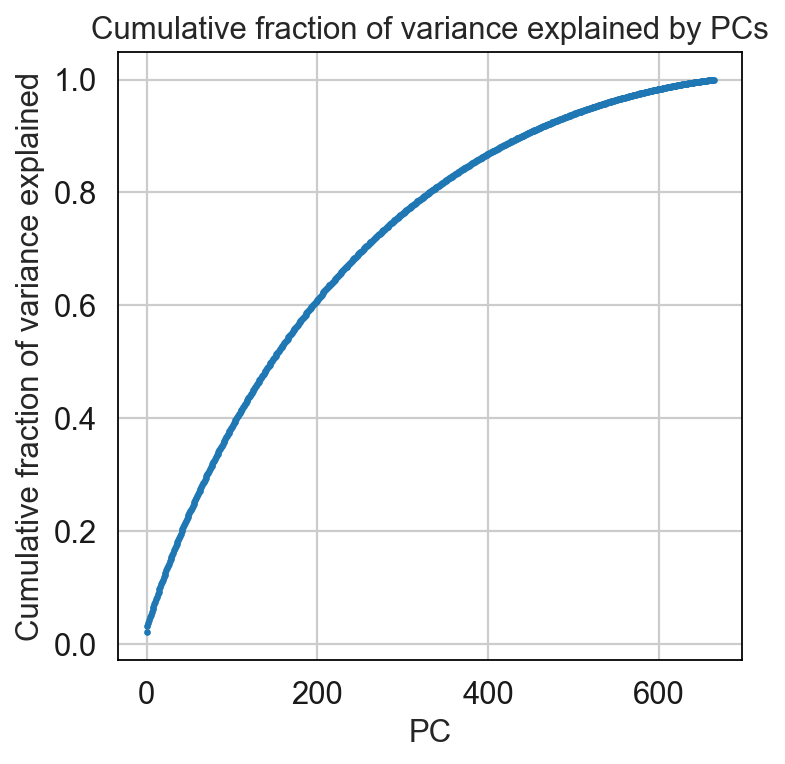

Knee point: 17
Explained variance: 0.10501216


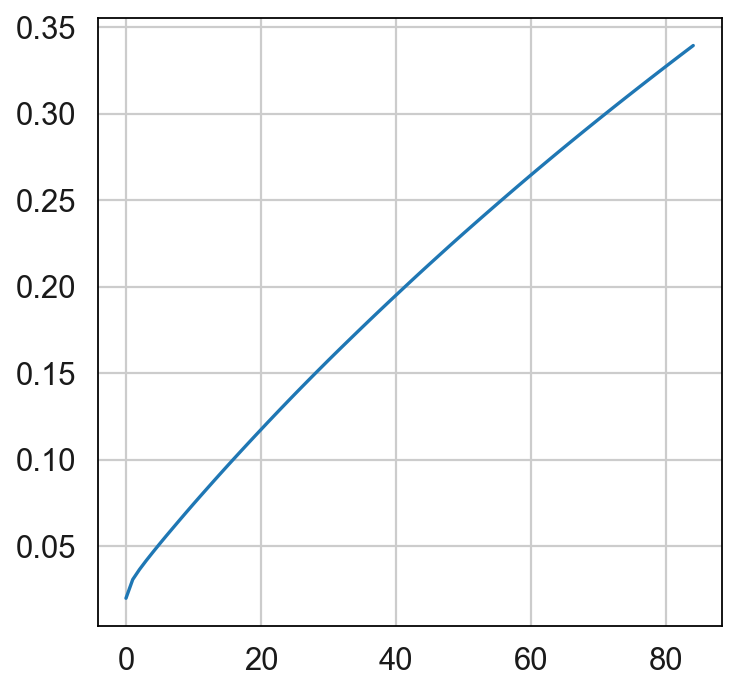

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


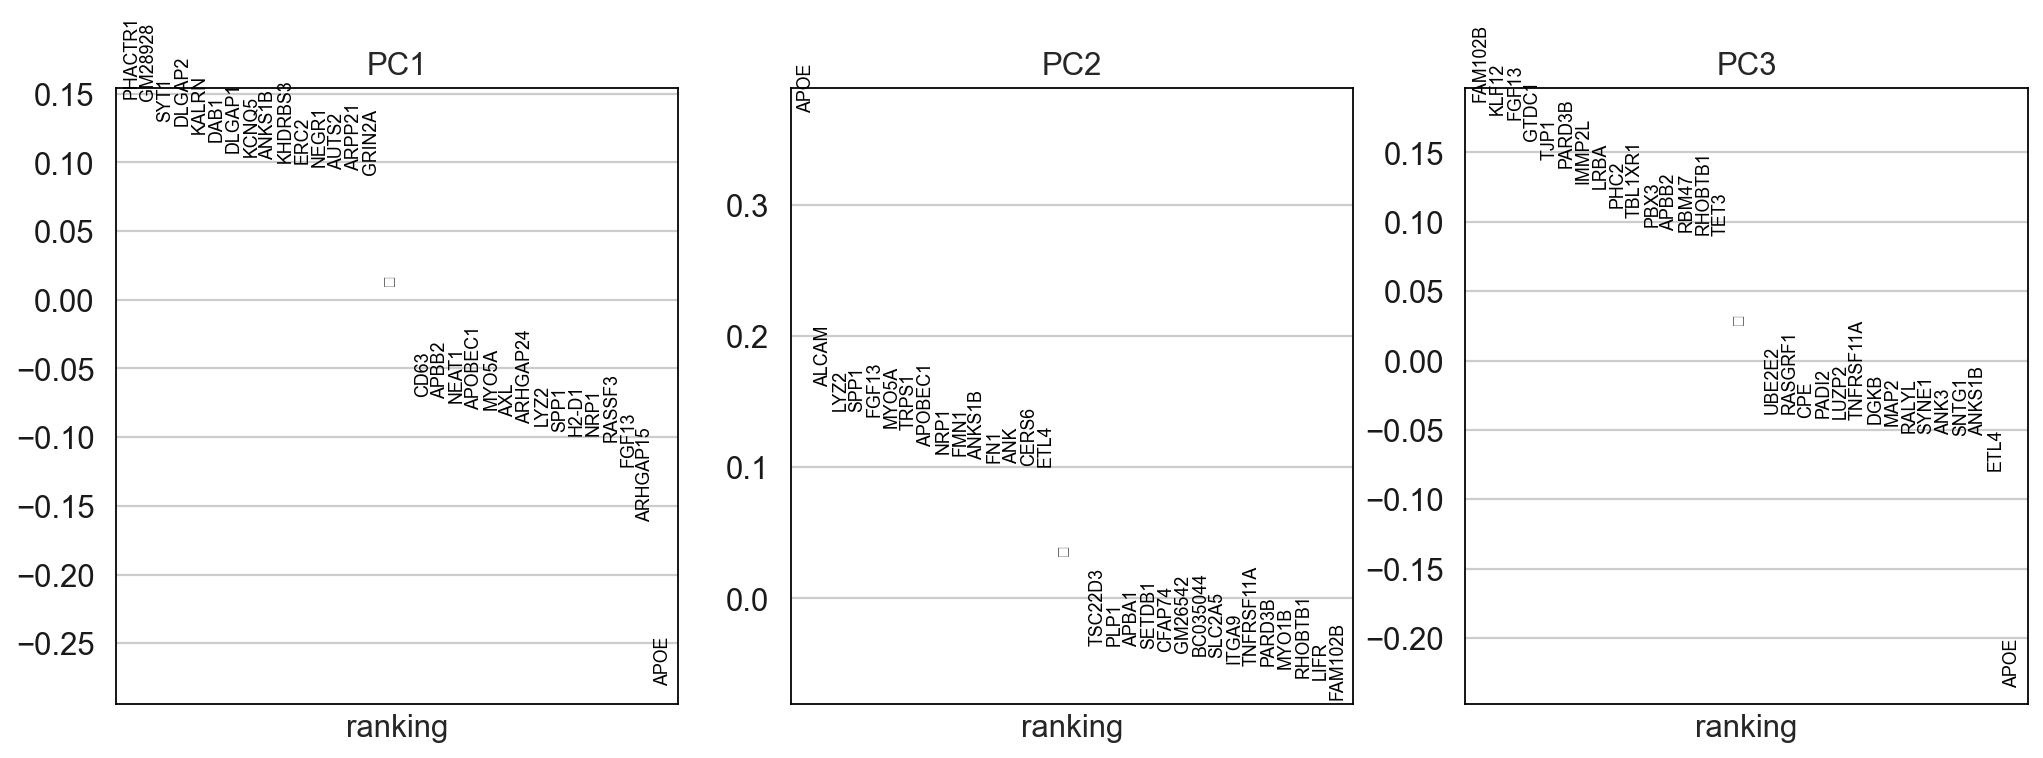

(666, 9644)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [21]:
sc.set_figure_params(figsize=(5, 5))
adata_microglia_only = run_pca_knee(adata_microglia_only)#, 0.5)
adata_microglia_only.obs['PC 1'] = adata_microglia_only.obsm['X_pca'][:,0] # optional
adata_microglia_only.obs['PC 2'] = adata_microglia_only.obsm['X_pca'][:,1]
adata_microglia_only.obs['PC 3'] = adata_microglia_only.obsm['X_pca'][:,2]

print(adata_microglia_only.shape)
adata_microglia_only.X = pd.DataFrame(adata_microglia_only.X).fillna(0).values
index_list = np.arange(adata_microglia_only.shape[0])
np.random.shuffle(index_list)
adata_microglia_only = adata_microglia_only[index_list,:]

In [22]:
print(adata_microglia_only.shape)
adata_microglia_only.X = pd.DataFrame(adata_microglia_only.X).fillna(0).values
index_list = np.arange(adata_microglia_only.shape[0])
np.random.shuffle(index_list)
adata_microglia_only = adata_microglia_only[index_list,:]

(666, 9644)


### Phenograph

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.0657200813293457 seconds
Jaccard graph constructed in 1.0327880382537842 seconds
Wrote graph to binary file in 0.009310007095336914 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.653365
After 9 runs, maximum modularity is Q = 0.654637
After 19 runs, maximum modularity is Q = 0.656666
Louvain completed 39 runs in 1.6985692977905273 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 3.544156074523926 seconds


Trying to set attribute `.obs` of view, copying.


Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.012735128402709961 seconds
Jaccard graph constructed in 0.836298942565918 seconds
Wrote graph to binary file in 0.014313936233520508 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.600279
After 11 runs, maximum modularity is Q = 0.604969
Louvain completed 31 runs in 0.4535398483276367 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 1.955578088760376 seconds
Finding 20 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.014086008071899414 seconds
Jaccard graph constructed in 0.8287596702575684 seconds
Wrote graph to binary file in 0.09218597412109375 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.573001
After 2 runs, maximum modularity is Q = 0.578915
After 8 runs, maximum modularity is Q = 0.580447
Louvain completed 28 runs in 0.4665079116821289 

Text(0.5, 0, 'k')

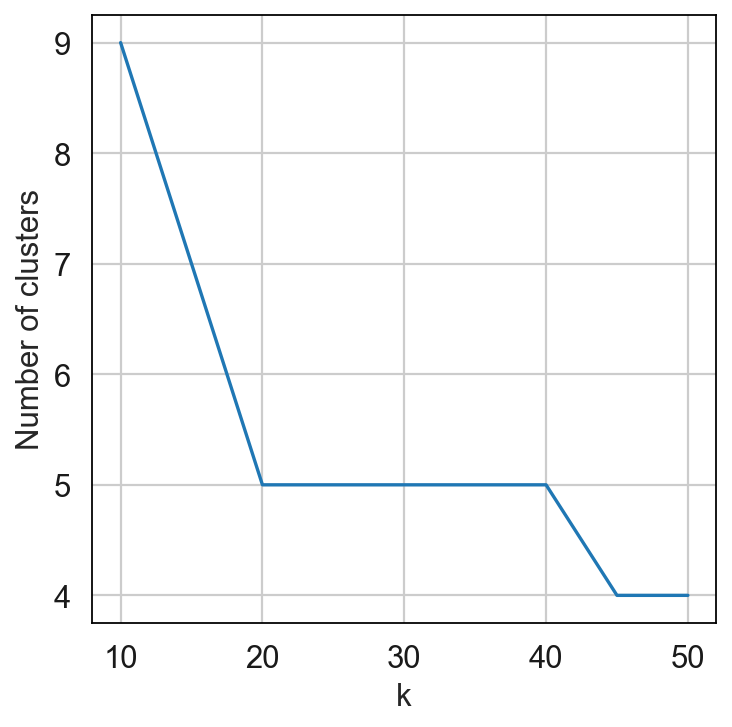

In [23]:
k_list = list(range(10, 55, 5))
n_clusters = []
for k in k_list:
    communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata_microglia_only.obsm['X_pca']),k=k)
    n_clusters.append(len(np.unique(communities)))
    adata_microglia_only.obs['PhenoGraph_clusters_mic_only'+str(k)] = pd.Categorical(communities)
    adata_microglia_only.uns['PhenoGraph_Q_'+str(k)] = Q
    adata_microglia_only.uns['PhenoGraph_k_'+str(k)] = k
plt.plot(k_list,n_clusters)
plt.ylabel("Number of clusters")
plt.xlabel("k")

In [24]:
Rand_index_df = pd.DataFrame(np.zeros((len(k_list), len(k_list))),index=k_list,columns=k_list)
Rand_index_df.index.name='k1'
Rand_index_df.columns.name='k2'
row_ind = 0
for run1 in range(len(k_list)):
    col_ind = 0
    for run2 in range(len(k_list)):
        Rand_index_df.iloc[row_ind,col_ind] = adjusted_rand_score(
            adata_microglia_only.obs['PhenoGraph_clusters_mic_only'+str(k_list[run1])].values,
            adata_microglia_only.obs['PhenoGraph_clusters_mic_only'+str(k_list[run2])].values)
        col_ind = col_ind+1
    row_ind = row_ind+1
    

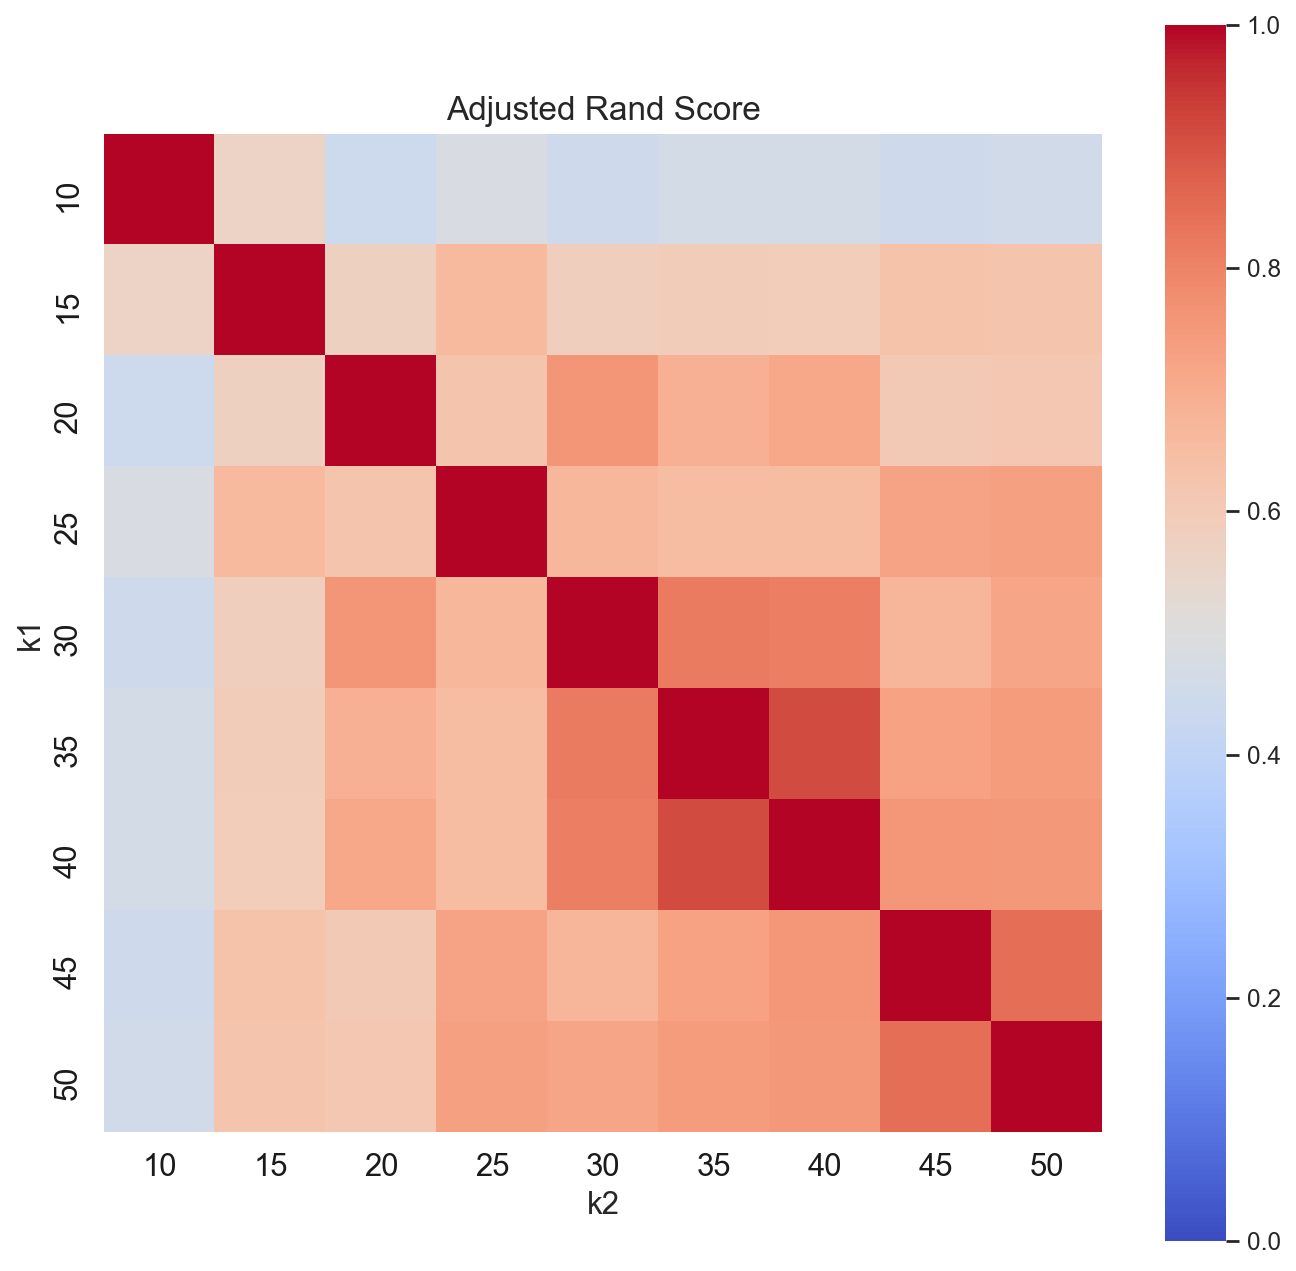

In [25]:
Rand_fig = plt.figure(figsize = (10,10))
plt.xlabel('k1')
plt.ylabel('k2')
plt.title('Adjusted Rand Score',fontsize=15)
sns.set(font_scale=1)
sns.heatmap(Rand_index_df, cmap=('coolwarm'), square=True, vmin=0, vmax=1)
# plt.colorbar(vmin=0)
plt.show();plt.close()


In [26]:
k = 40 # choose k
communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata_microglia_only.obsm['X_pca']),k=k) # run PhenoGraph
adata_microglia_only.obs['PhenoGraph_clusters_mic_only'] = pd.Categorical(communities)
adata_microglia_only.uns['PhenoGraph_Q'] = Q
adata_microglia_only.uns['PhenoGraph_k'] = k

Finding 40 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.015539884567260742 seconds
Jaccard graph constructed in 0.9037590026855469 seconds
Wrote graph to binary file in 0.19355320930480957 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.517694
After 2 runs, maximum modularity is Q = 0.519433
Louvain completed 22 runs in 0.37906408309936523 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 2.137701988220215 seconds


### Vizualize Microglia sub-clusters

In [27]:
sc.pp.neighbors(adata_microglia_only, method='umap', use_rep='X_pca')
sc.tl.umap(adata_microglia_only, random_state=None)

... storing 'Condition' as categorical
... storing 'B_region' as categorical


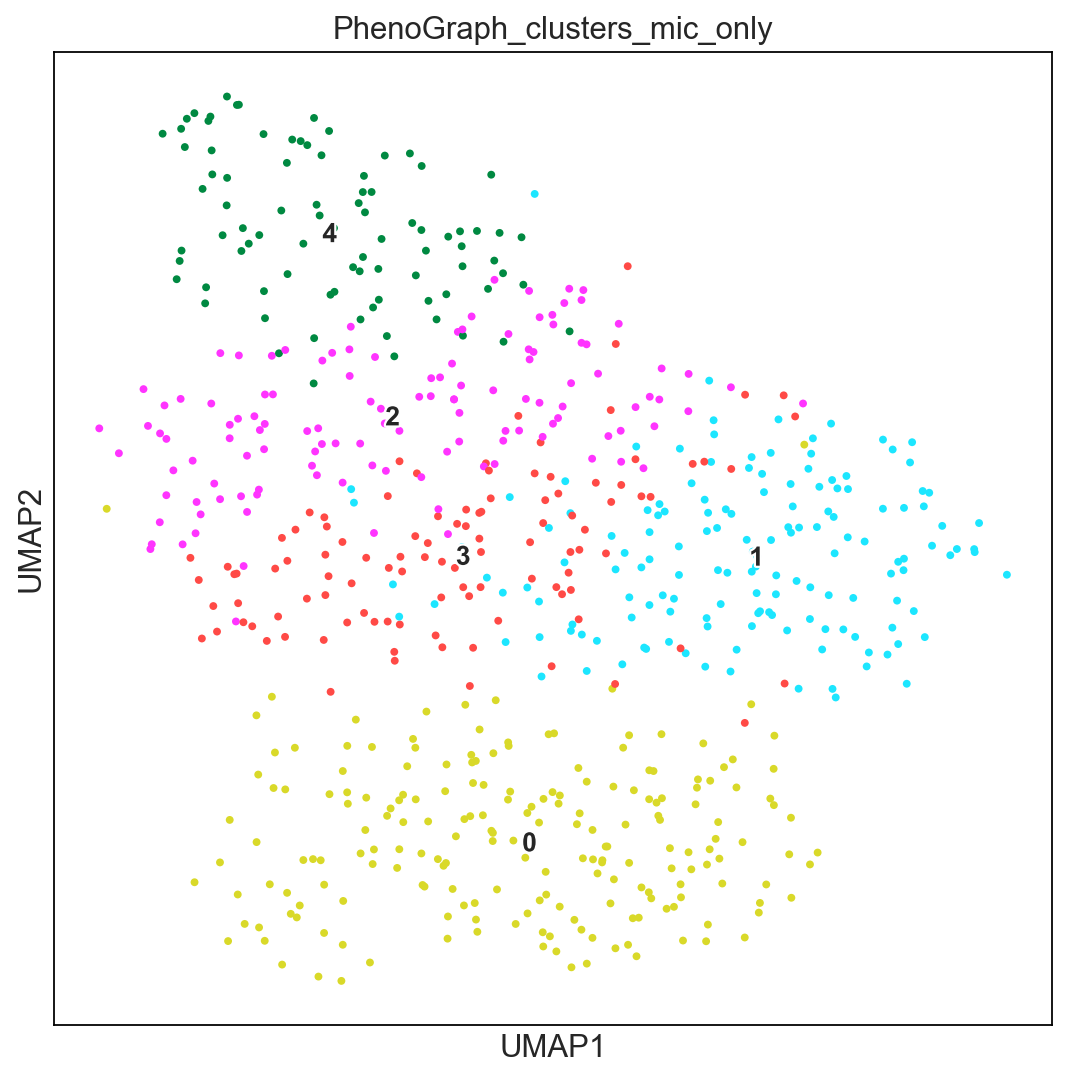

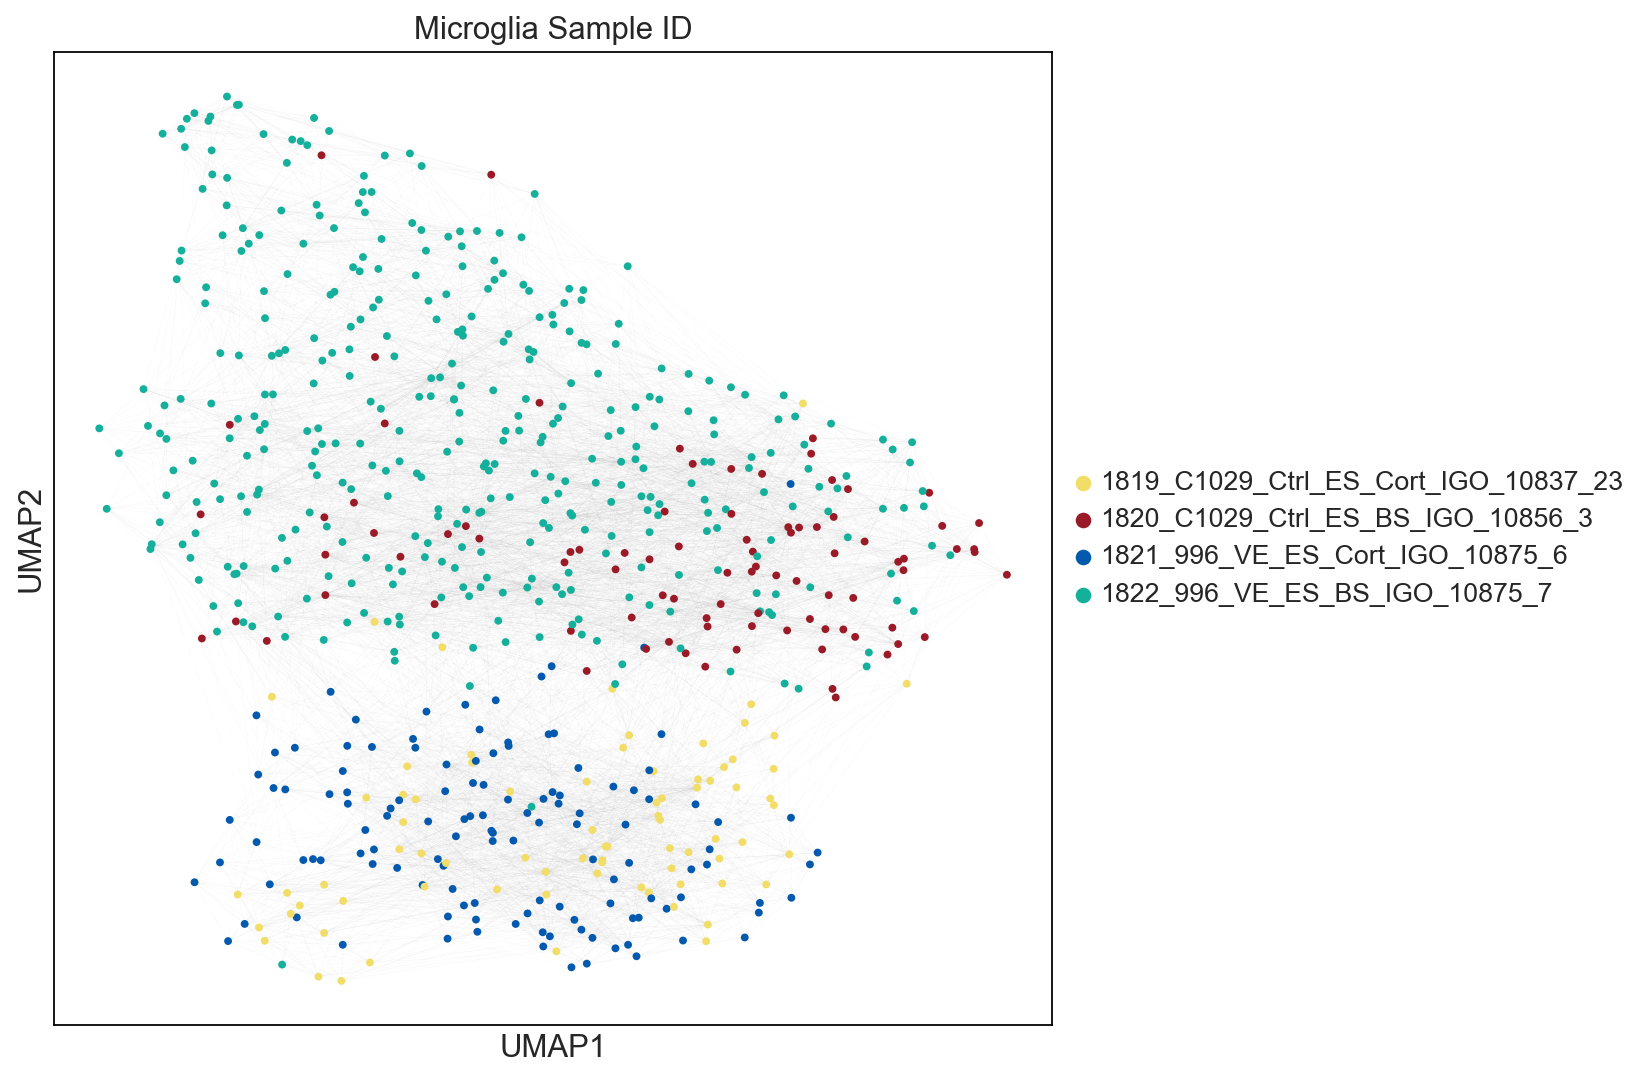

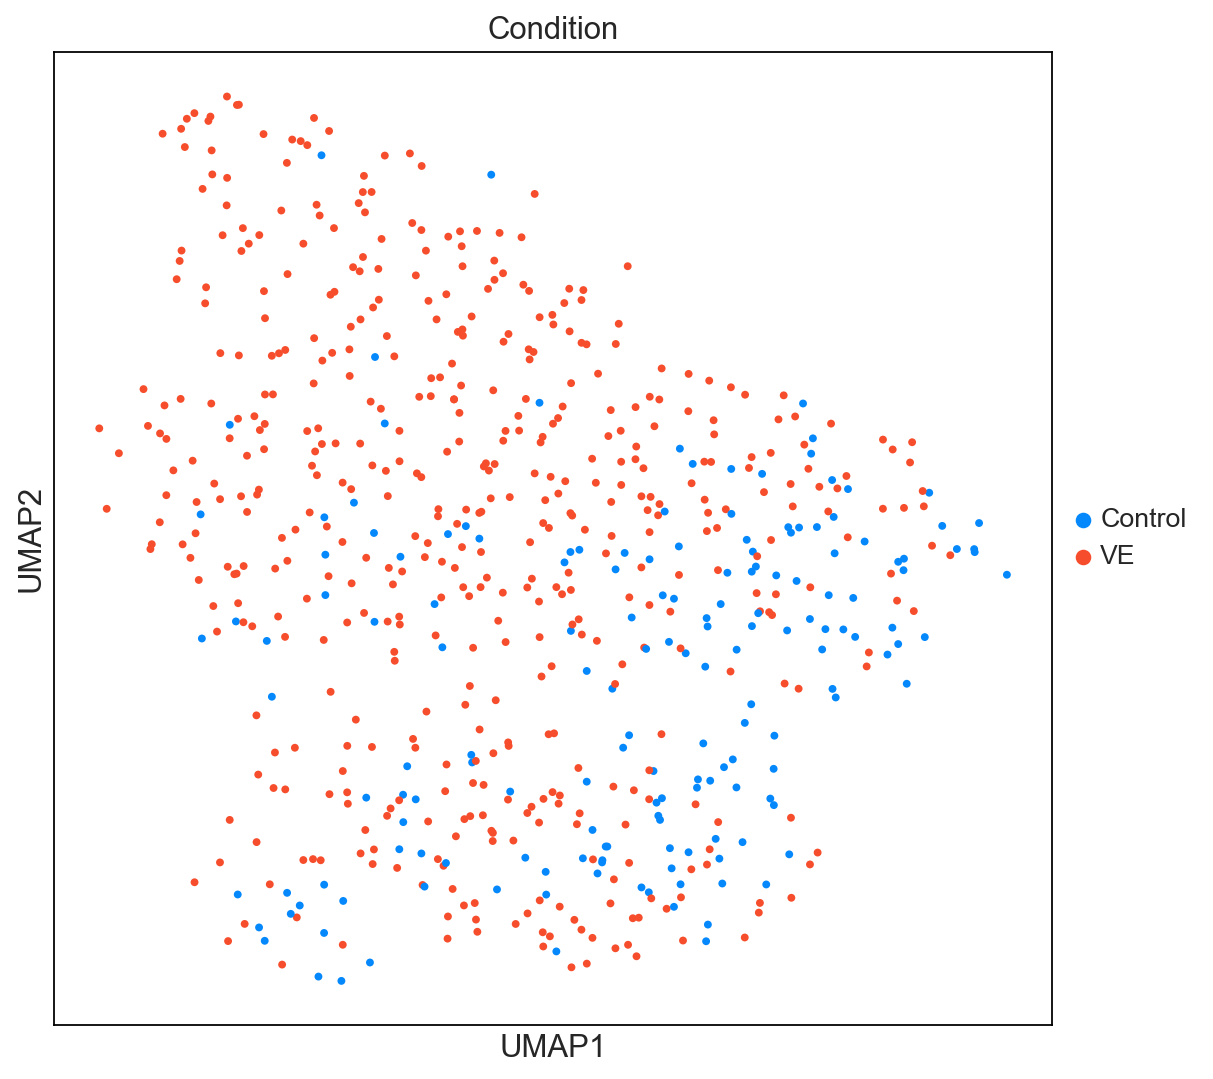

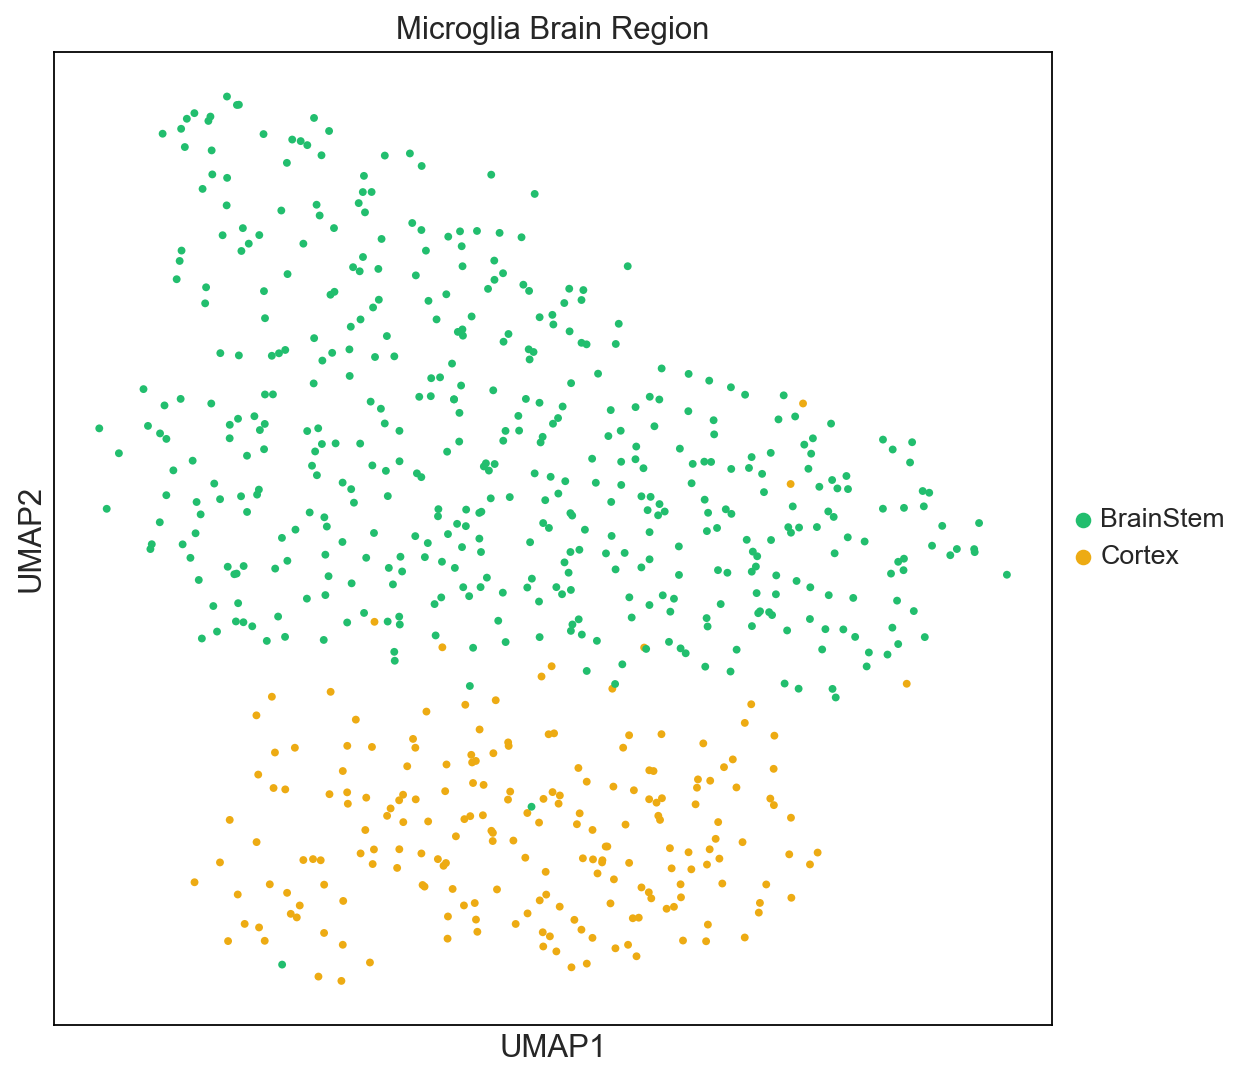

In [28]:
sc.set_figure_params(figsize=(8, 8))

#adata_microglia_VE = adata_microglia.copy()
#adata_microglia_VE = adata_microglia_VE[adata_microglia_VE.obs.Condition == 'VE']

#adata_microglia_WT = adata_microglia.copy()
#adata_microglia_WT = adata_microglia_WT[adata_microglia_WT.obs.Condition == 'Control']


sc.pl.umap(
    adata_microglia_only,
    color=['PhenoGraph_clusters_mic_only'],
    ncols=2,
    sort_order=False,
    #edges = True,
    palette=godsnot_64, # 'palette' specifies the colormap to use
    cmap='Spectral_r',
    legend_loc='on data',
    legend_fontsize=12, size = 50,
    legend_fontoutline=2,
    #save= '_immune_cells_PhenoGraph_clusters'
)

sc.pl.umap(adata_microglia_only, 
           color= ['Sample ID'],
           ncols=2,
           edges = True,
           edges_width= 0.01,
           palette= ["#F2DD66", "#9A1B27", "#0359AE", "#14B09B"],
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Microglia Sample ID"])

sc.pl.umap(adata_microglia_only,
           color=['Condition'],
           ncols=2,
           sort_order=False,
           palette=['#0488FC','#F64E2C'], # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_fontsize=12, size = 50, frameon = True,
           legend_fontoutline=2)

sc.pl.umap(adata_microglia_only, 
           color= ['B_region'],
           ncols=2,
           palette= ["#22BE6E", "#EDAB13"],
           size=50, 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Microglia Brain Region"])


### Find markers (Microglia clusters)

In [29]:
cl_int_to_str = dict()
cl_int_to_str = {
    0 : 'Mic0',
    1 : 'Mic1',
    2 : 'Mic2',
    3 : 'Mic3',
    4 : 'Mic4'}

adata_microglia_only.obs['PhenoGraph_clusters_mic_only_str'] = adata_microglia_only.obs['PhenoGraph_clusters_mic_only'].map(cl_int_to_str).astype('category')

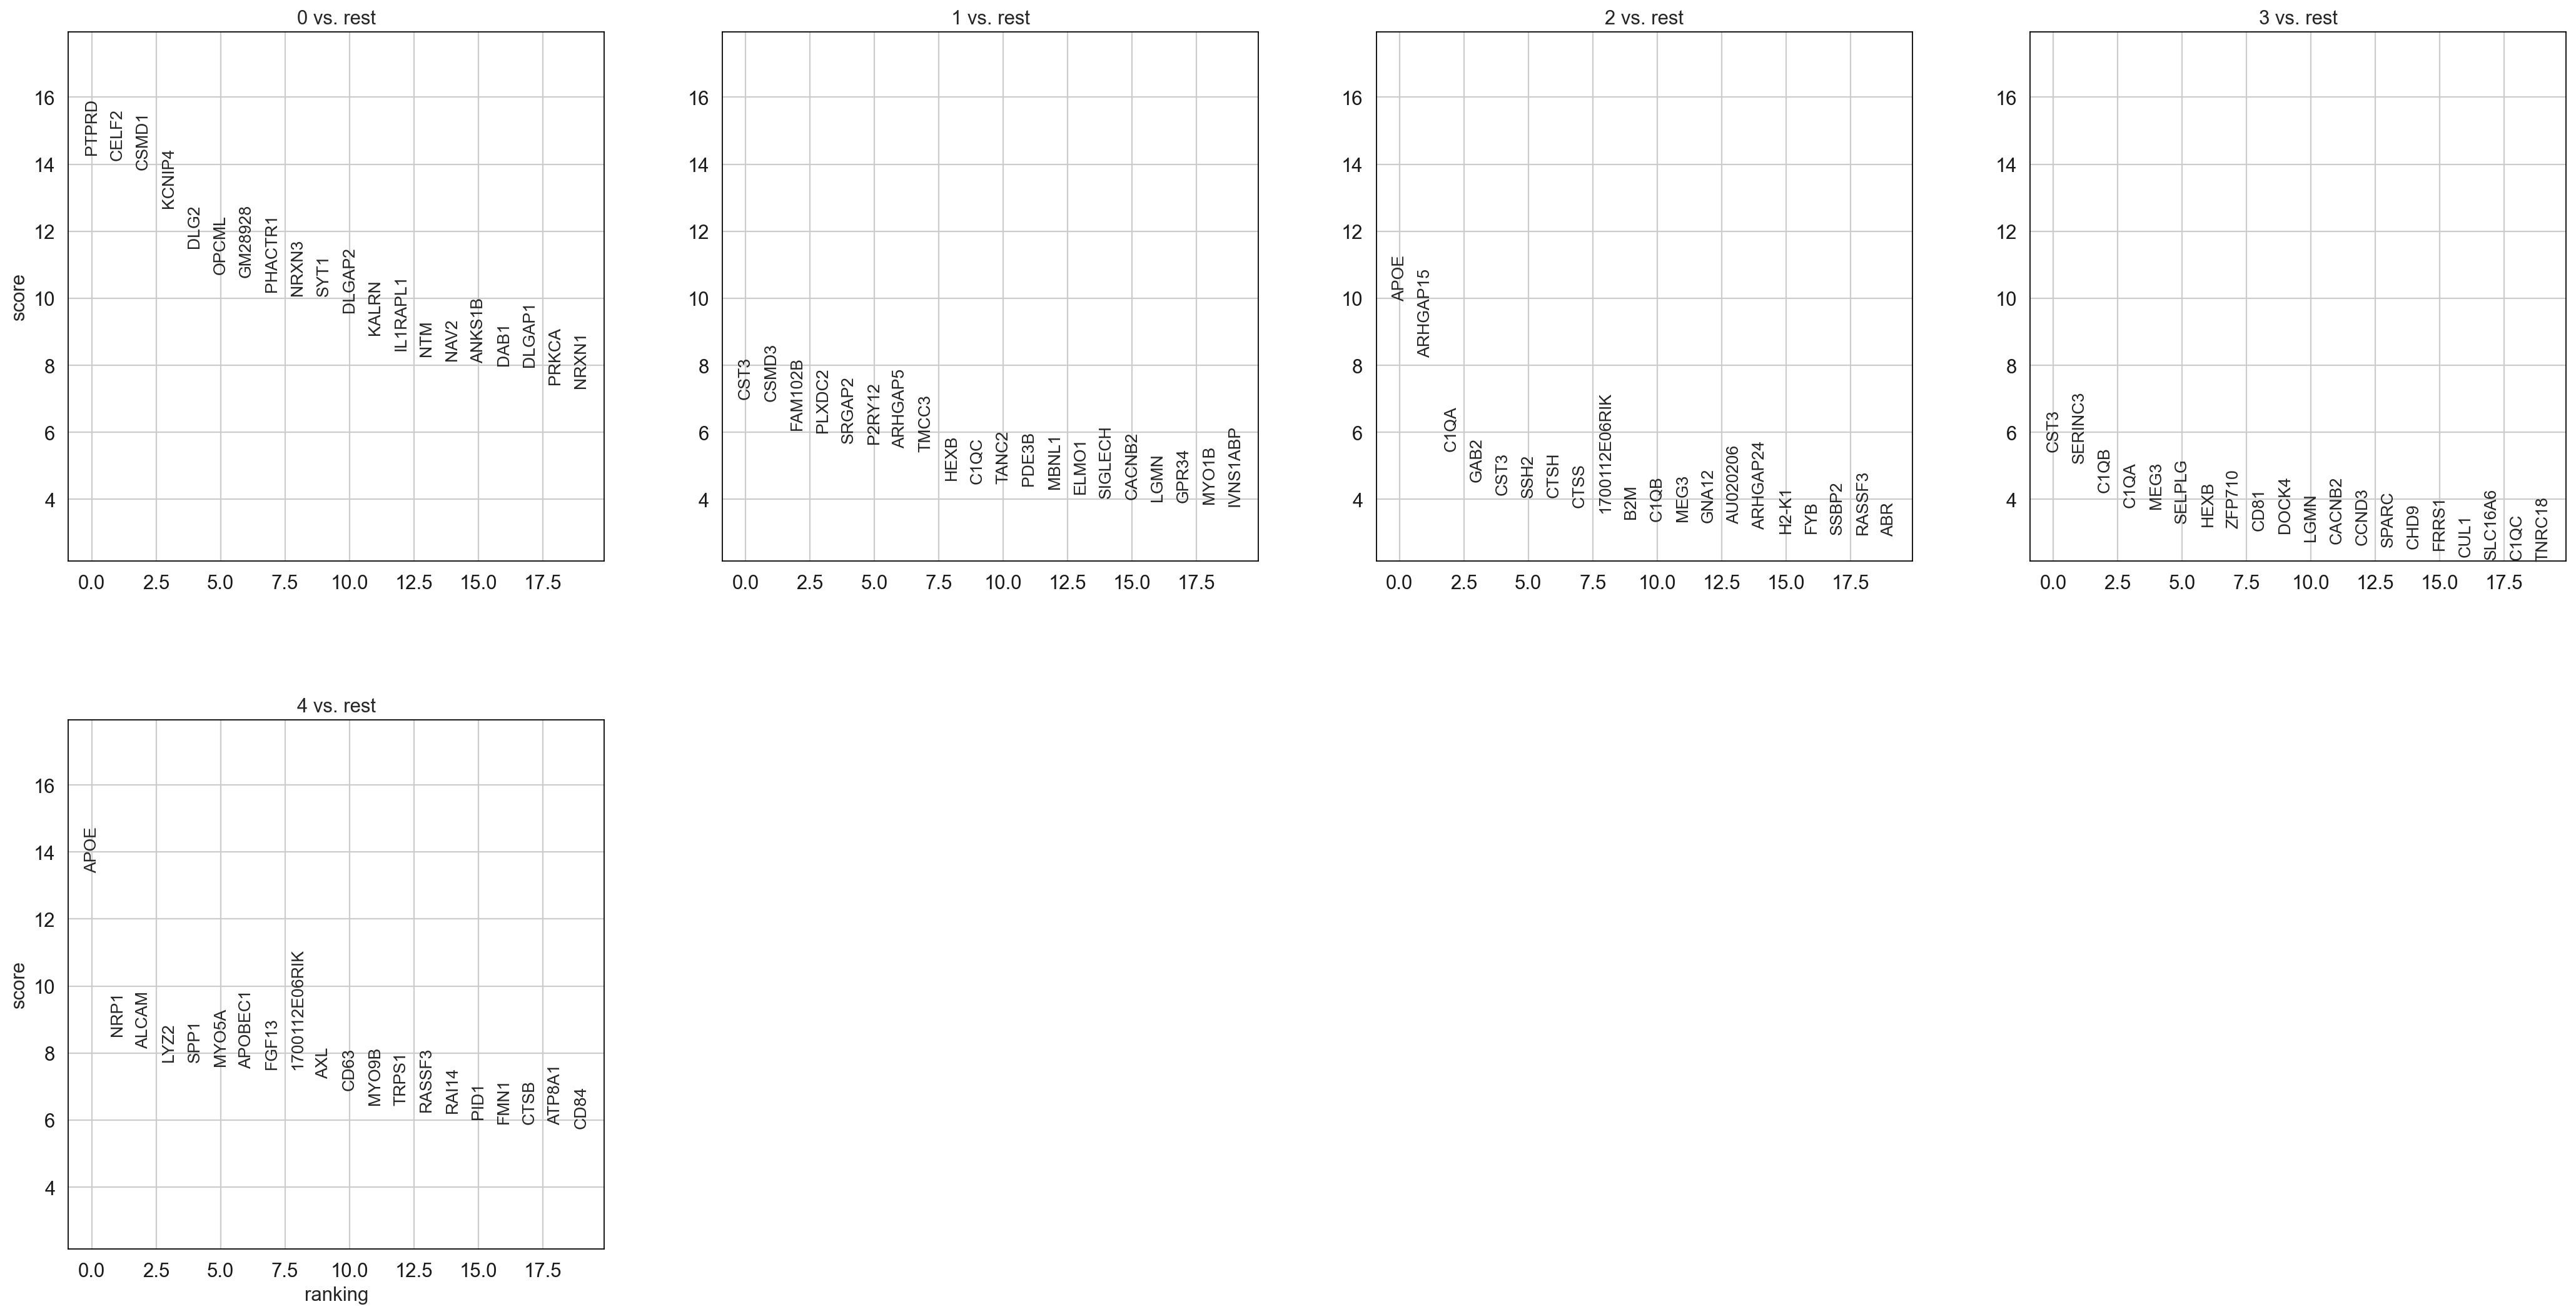

In [30]:
sc.tl.rank_genes_groups(adata_microglia_only, groupby='PhenoGraph_clusters_mic_only', key_added="ranked_genes_pheno_mic_only", method='wilcoxon')
sc.pl.rank_genes_groups(adata_microglia_only, key = 'ranked_genes_pheno_mic_only', fontsize=12)

### Visualize marker genes using heatmap

In [31]:
adata_microglia_only.layers['scaled'] = sc.pp.scale(adata_microglia_only, copy=True).X

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


{'heatmap_ax': <AxesSubplot:>,
 'groupby_ax': <AxesSubplot:xlabel='PhenoGraph_clusters_mic_only_str'>,
 'dendrogram_ax': <AxesSubplot:>,
 'gene_groups_ax': <AxesSubplot:>}

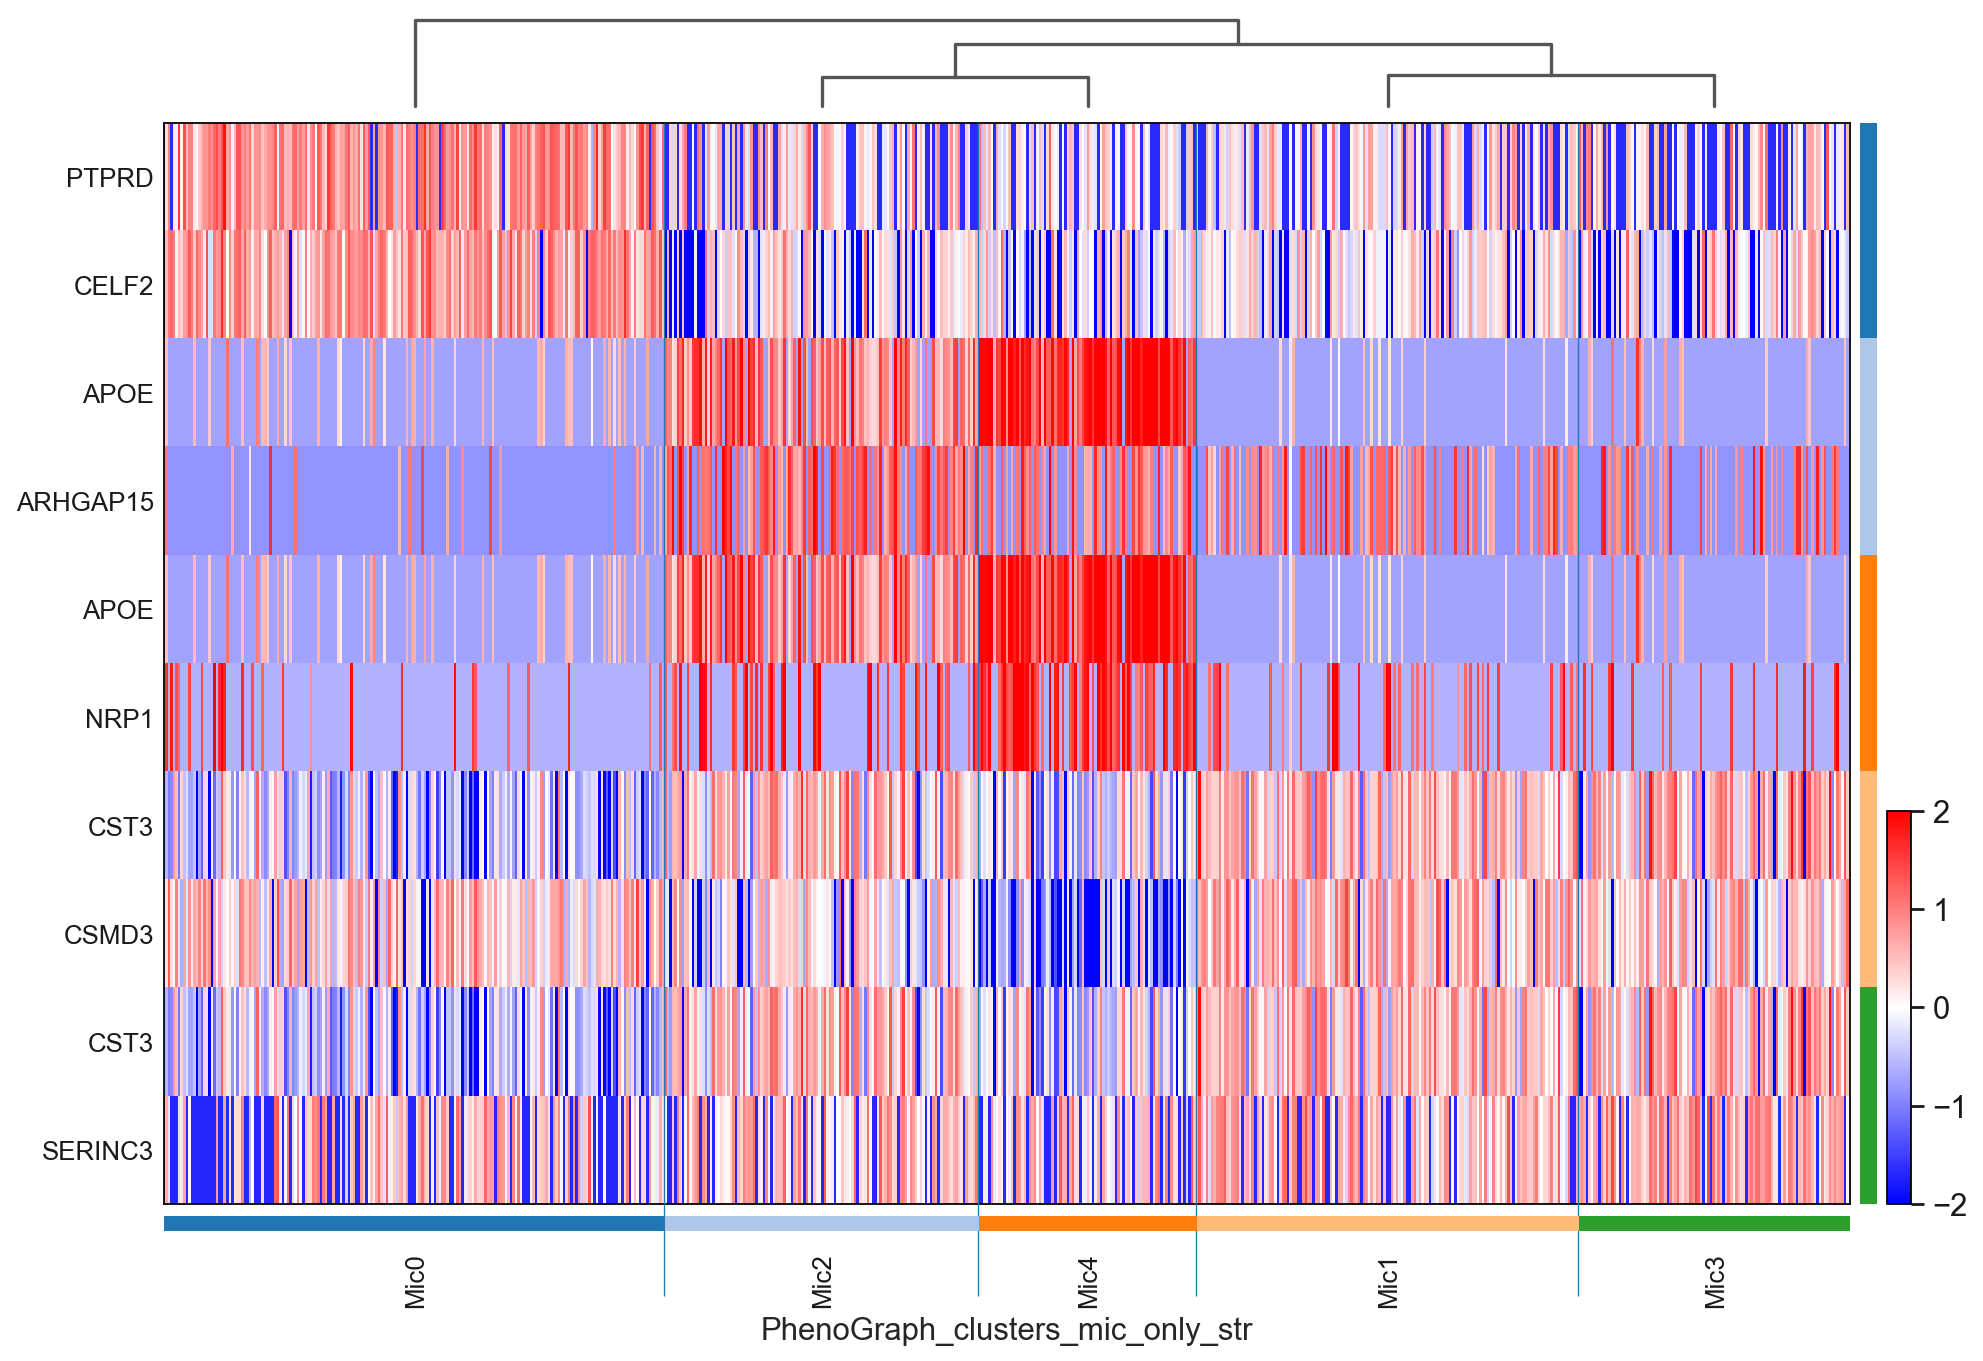

In [32]:
sc.tl.rank_genes_groups(adata_microglia_only, groupby='PhenoGraph_clusters_mic_only_str', n_genes=adata_microglia_only.shape[1], method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata_microglia_only, n_genes=2, use_raw=False, swap_axes=True, vmin=-2, vmax=2, cmap='bwr', layer='scaled', figsize=(14,10), show=False)

In [33]:
adata_microglia_only.obs['PhenoGraph_clusters_mic_only_str'].value_counts()

Mic0    198
Mic1    151
Mic2    124
Mic3    107
Mic4     86
Name: PhenoGraph_clusters_mic_only_str, dtype: int64

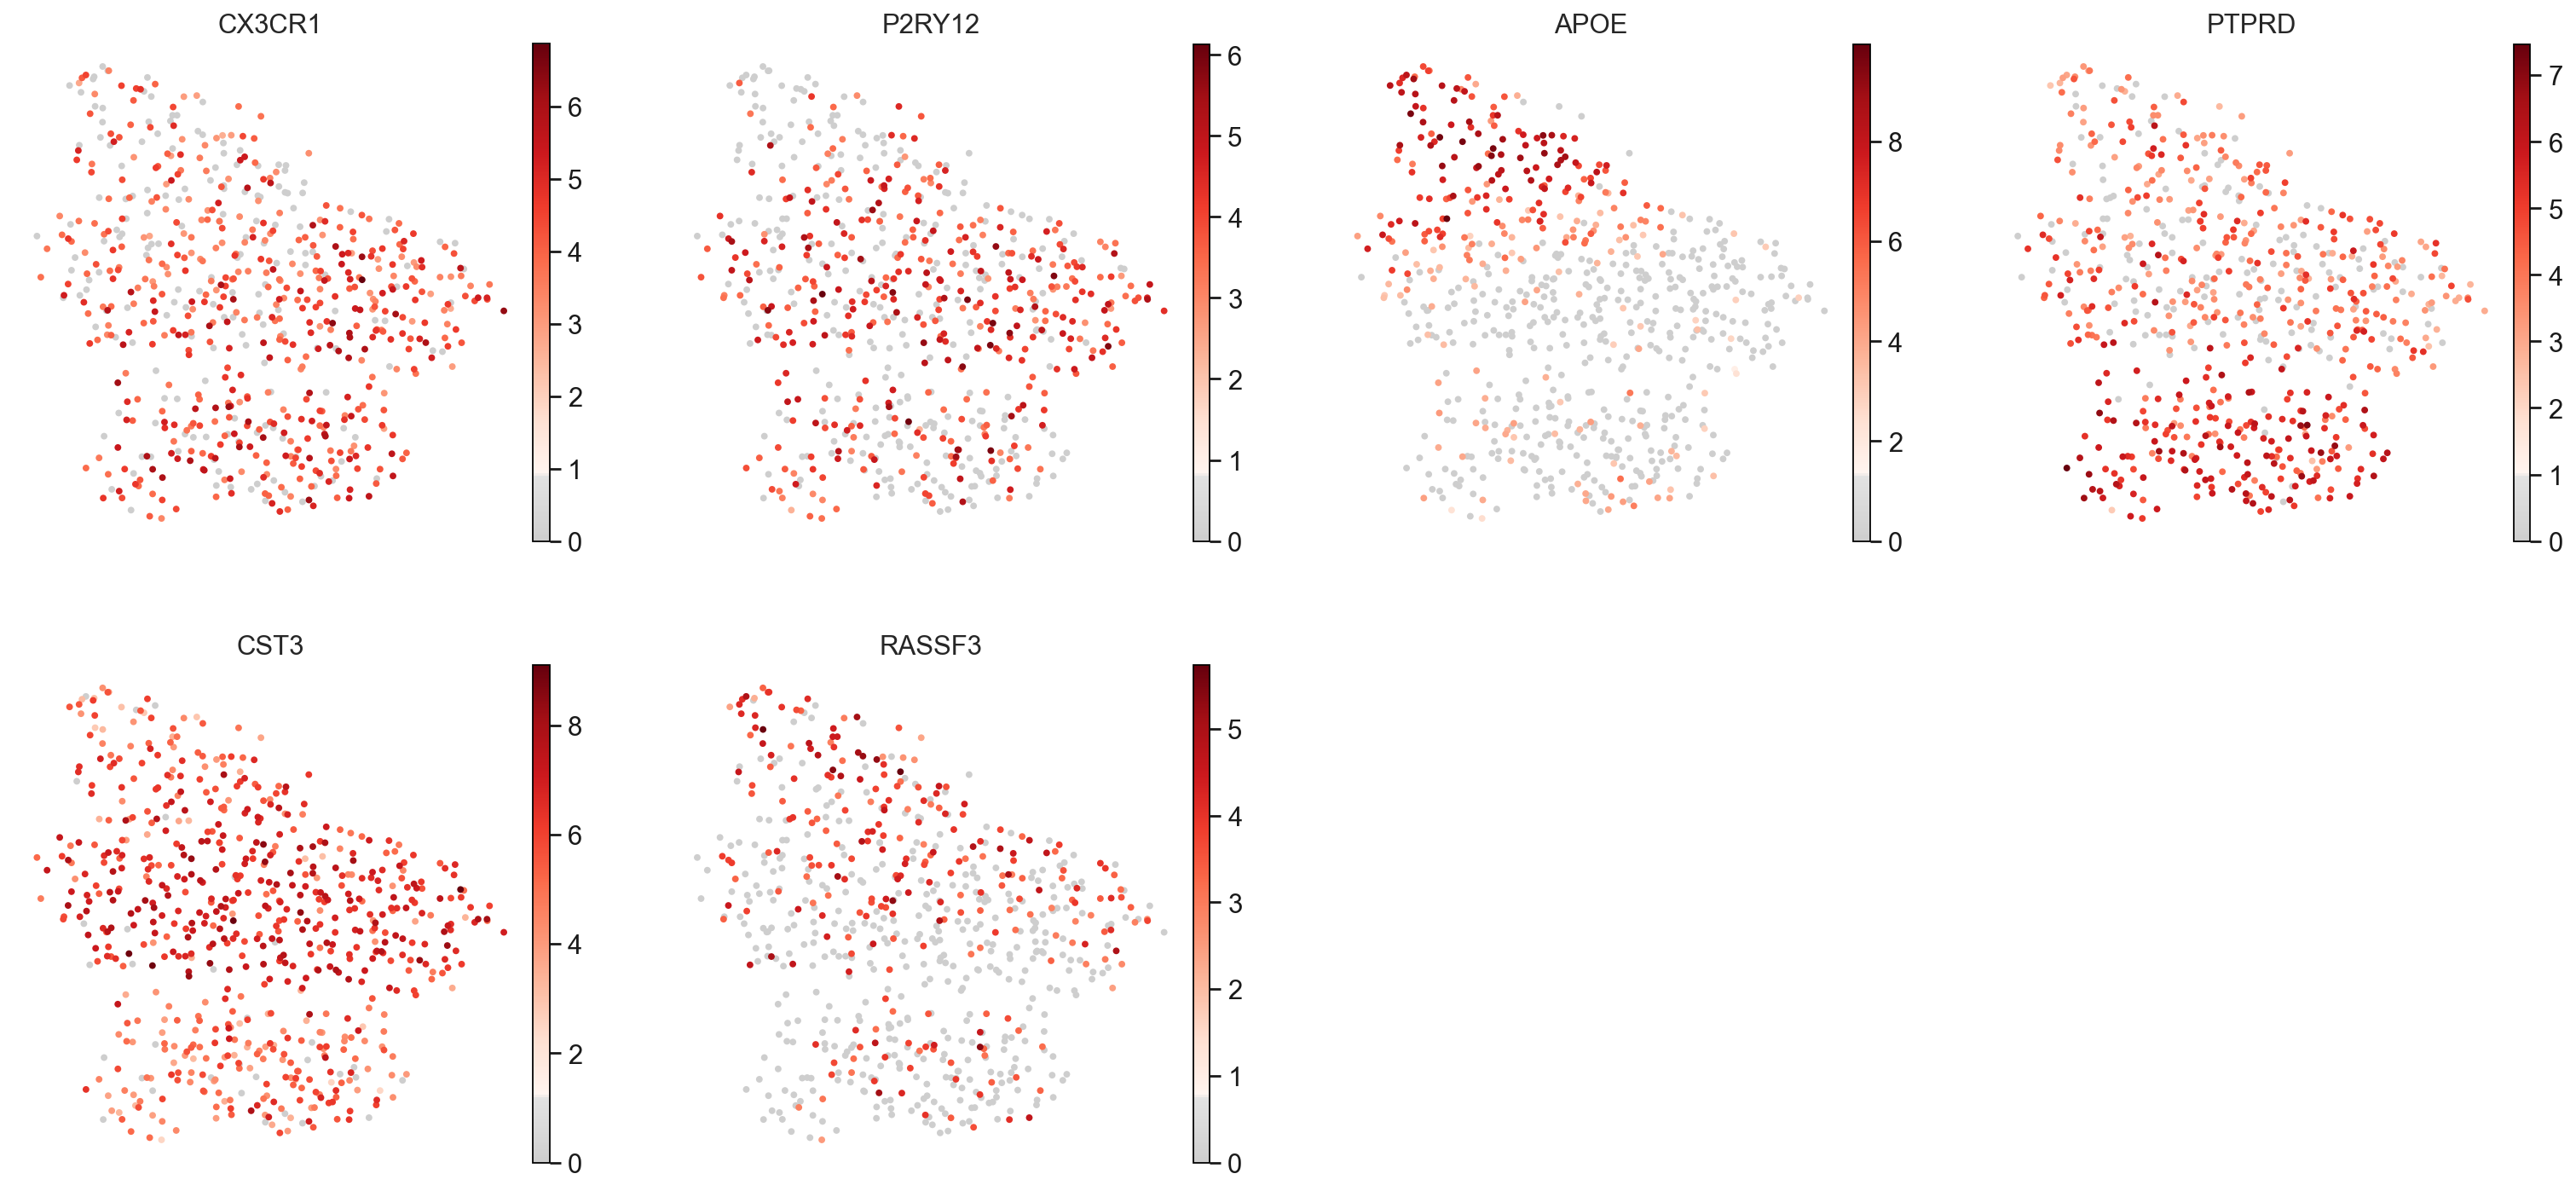

In [142]:
sc.set_figure_params(figsize=(5, 5))
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
 
sc.pl.umap(adata_microglia_only,
           size = 50,
           color=['CX3CR1','P2RY12','APOE','PTPRD','CST3', 'RASSF3'],
           color_map=mymap,
          frameon=False)


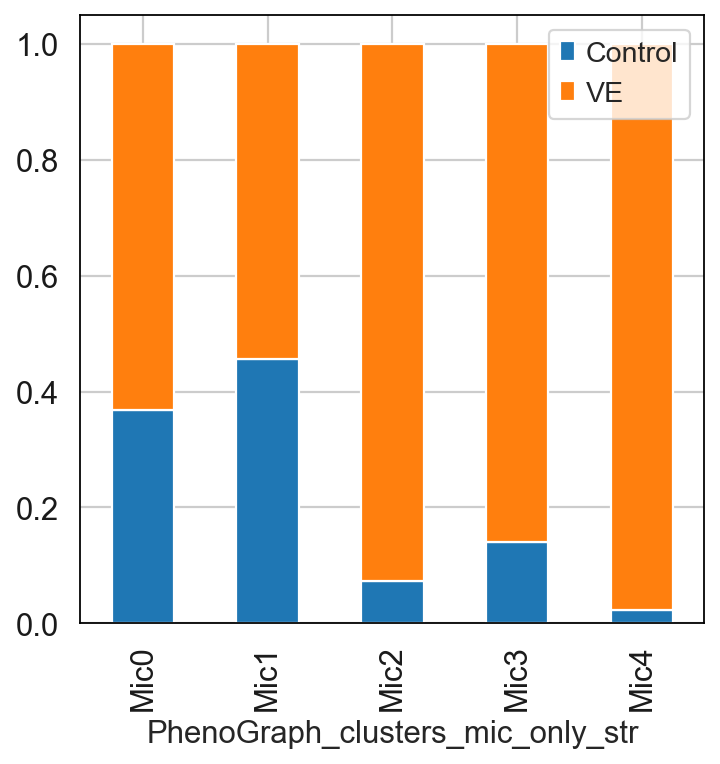

In [30]:
tmp = pd.crosstab(adata_microglia_only.obs['PhenoGraph_clusters_mic_only_str'],adata_microglia_only.obs['Condition'], normalize='index')
tmp.plot.bar(stacked=True).legend(loc='upper right')

### Save results Adata ONLY microglia

In [35]:
#adata_microglia_only.write_h5ad(outdir+'adata_high_var_Microglia_ONLY_clusters.h5ad')

In [11]:
adata_microglia_only = sc.read_h5ad(outdir+'adata_high_var_Microglia_ONLY_clusters.h5ad')

### Differential expression with MAST for Cortex & Brainstem

In [12]:
cell_type = 'microglia_only'
expmat = pd.DataFrame(adata_microglia_only.X, columns = adata_microglia_only.var.index, index = adata_microglia_only.obs.index)
cdata = pd.DataFrame(adata_microglia_only.obs, columns=adata_microglia_only.obs.columns, index = adata_microglia_only.obs.index)
expmat.to_csv(r'DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv', index=True)
cdata.to_csv(r'DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv', index=True)

In [13]:
start_time = timeit.default_timer()
MAST = './runMAST.R'
expmat_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
cdata_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
output_file_cort = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_cort.csv" 
output_file_bs = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_bs.csv"

os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " + output_file_bs)
out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)

### Heatmaps of gene expression

In [79]:
marker_genes_dict = dict()

marker_genes_dict = {'Microglia-BS':['APOE',
'ATP8A1',
'CTSH',
'PID1',
'RASSF3',
'MYO1F',
'AXL',
'APOBEC1',
'FTH1',
'MYO5A',
'RTN3',
'NRP1',
'PVT1',
'MYO9B',
'FMN1',
'RFTN1',
'CSF3R',
'MARCH3',
'SPP1','CST3']}


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


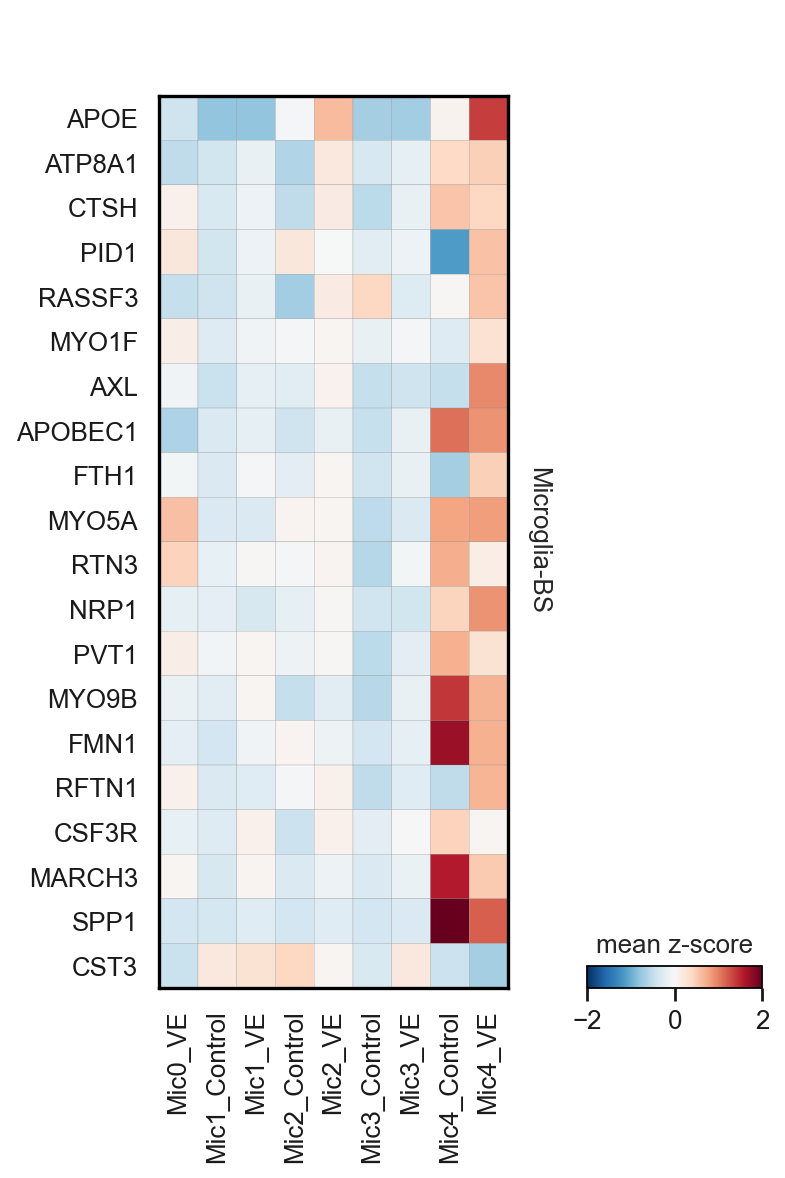

categories: Mic0_VE, Mic1_Control, Mic1_VE, etc.
var_group_labels: Microglia-BS


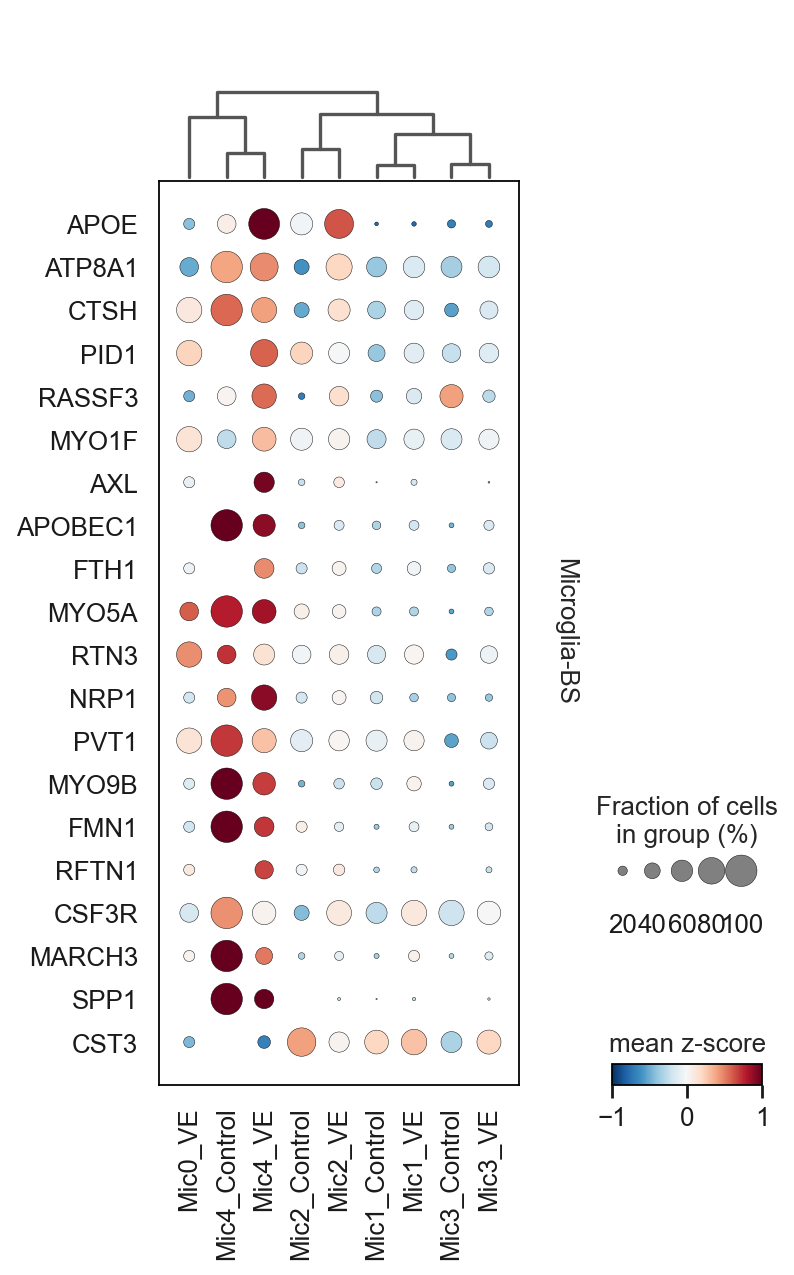

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


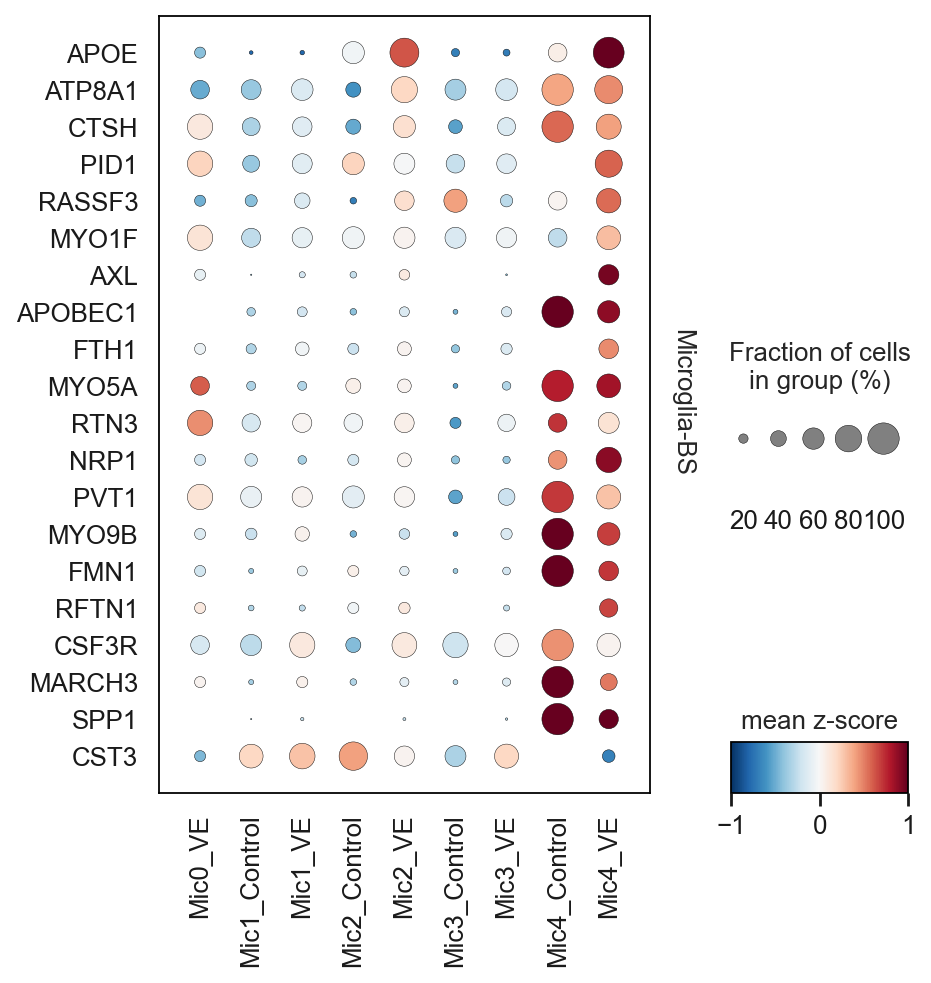

In [80]:
adata_microglia_BS.layers['scaled'] = sc.pp.scale(adata_microglia_BS, copy=True).X
sc.pl.matrixplot(adata_microglia_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_mic_only_str','Condition'], dendrogram=False,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_microglia_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_mic_only_str','Condition'], dendrogram=True,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_microglia_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_mic_only_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True, figsize=(6,6))

In [120]:
my_genes= ['APOE']

[Text(0, 0, 'APOE')]

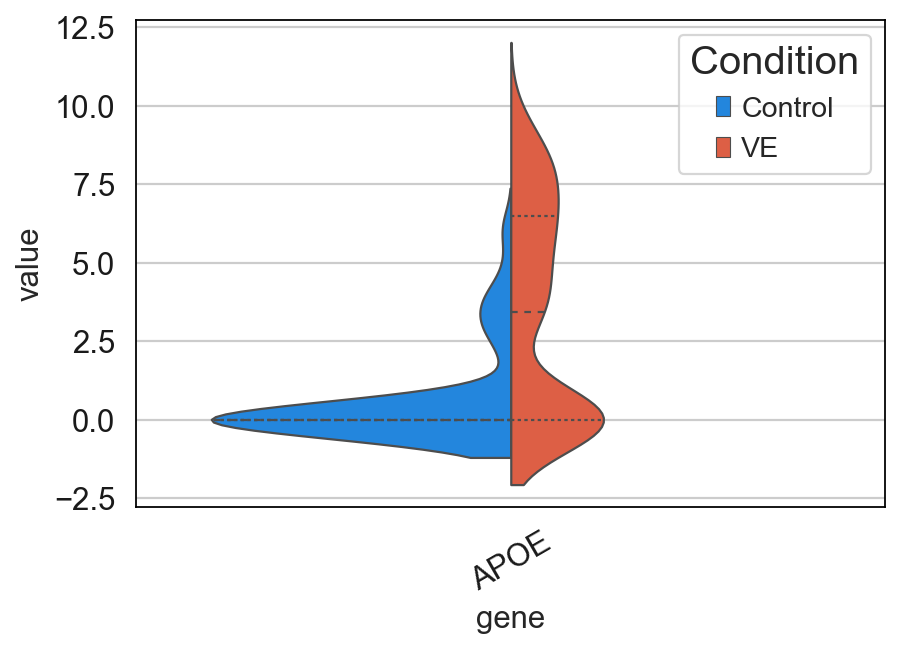

In [121]:
sc.set_figure_params(figsize=(6, 4))

colors_list = ['#0488FC','#F64E2C']
adata = adata_microglia_BS.copy()
df = sc.get.obs_df(adata, [*my_genes, 'Condition'])
df = df.set_index('Condition').stack().reset_index()
df.columns = ['Condition', 'gene', 'value']
import seaborn as sns
v = sns.violinplot(data=df, x='gene', y='value', hue="Condition",
                split=True, inner="quart", linewidth=1, palette=colors_list, legend = False)

v.set_xticklabels(v.get_xticklabels(), rotation=30)

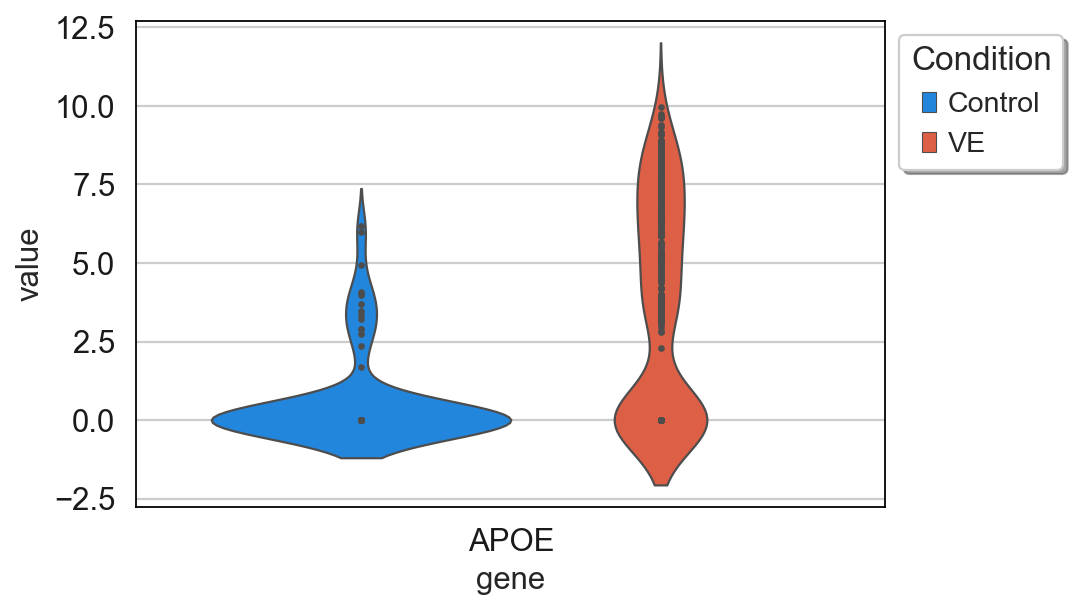

In [131]:
sc.set_figure_params(figsize=(6, 4))

v = sns.violinplot(data=df, x='gene', y='value', hue="Condition",
                split=False, inner="point", linewidth=1, palette=colors_list, legend = False)


v.legend(bbox_to_anchor=(1, 1), loc=2, title="Condition", \
               title_fontsize = 15, \
               shadow = True, \
               facecolor = 'white')

#v.set_xticklabels(v.get_xticklabels(), rotation=30)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an erro

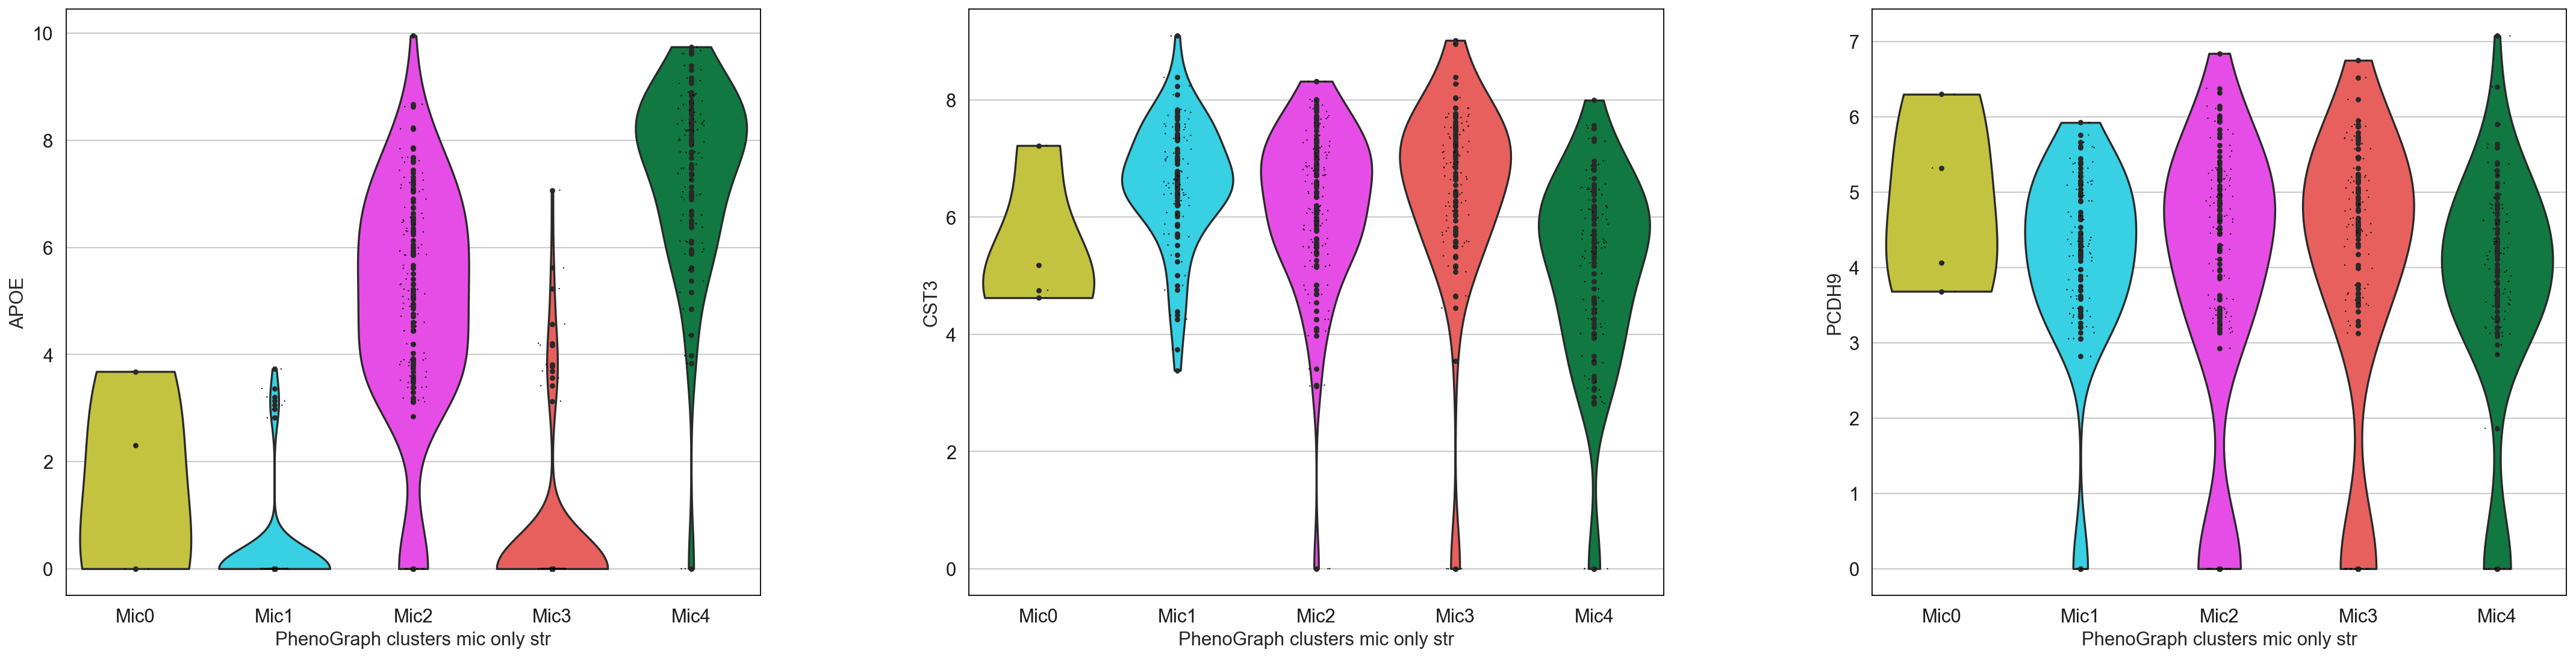

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an erro

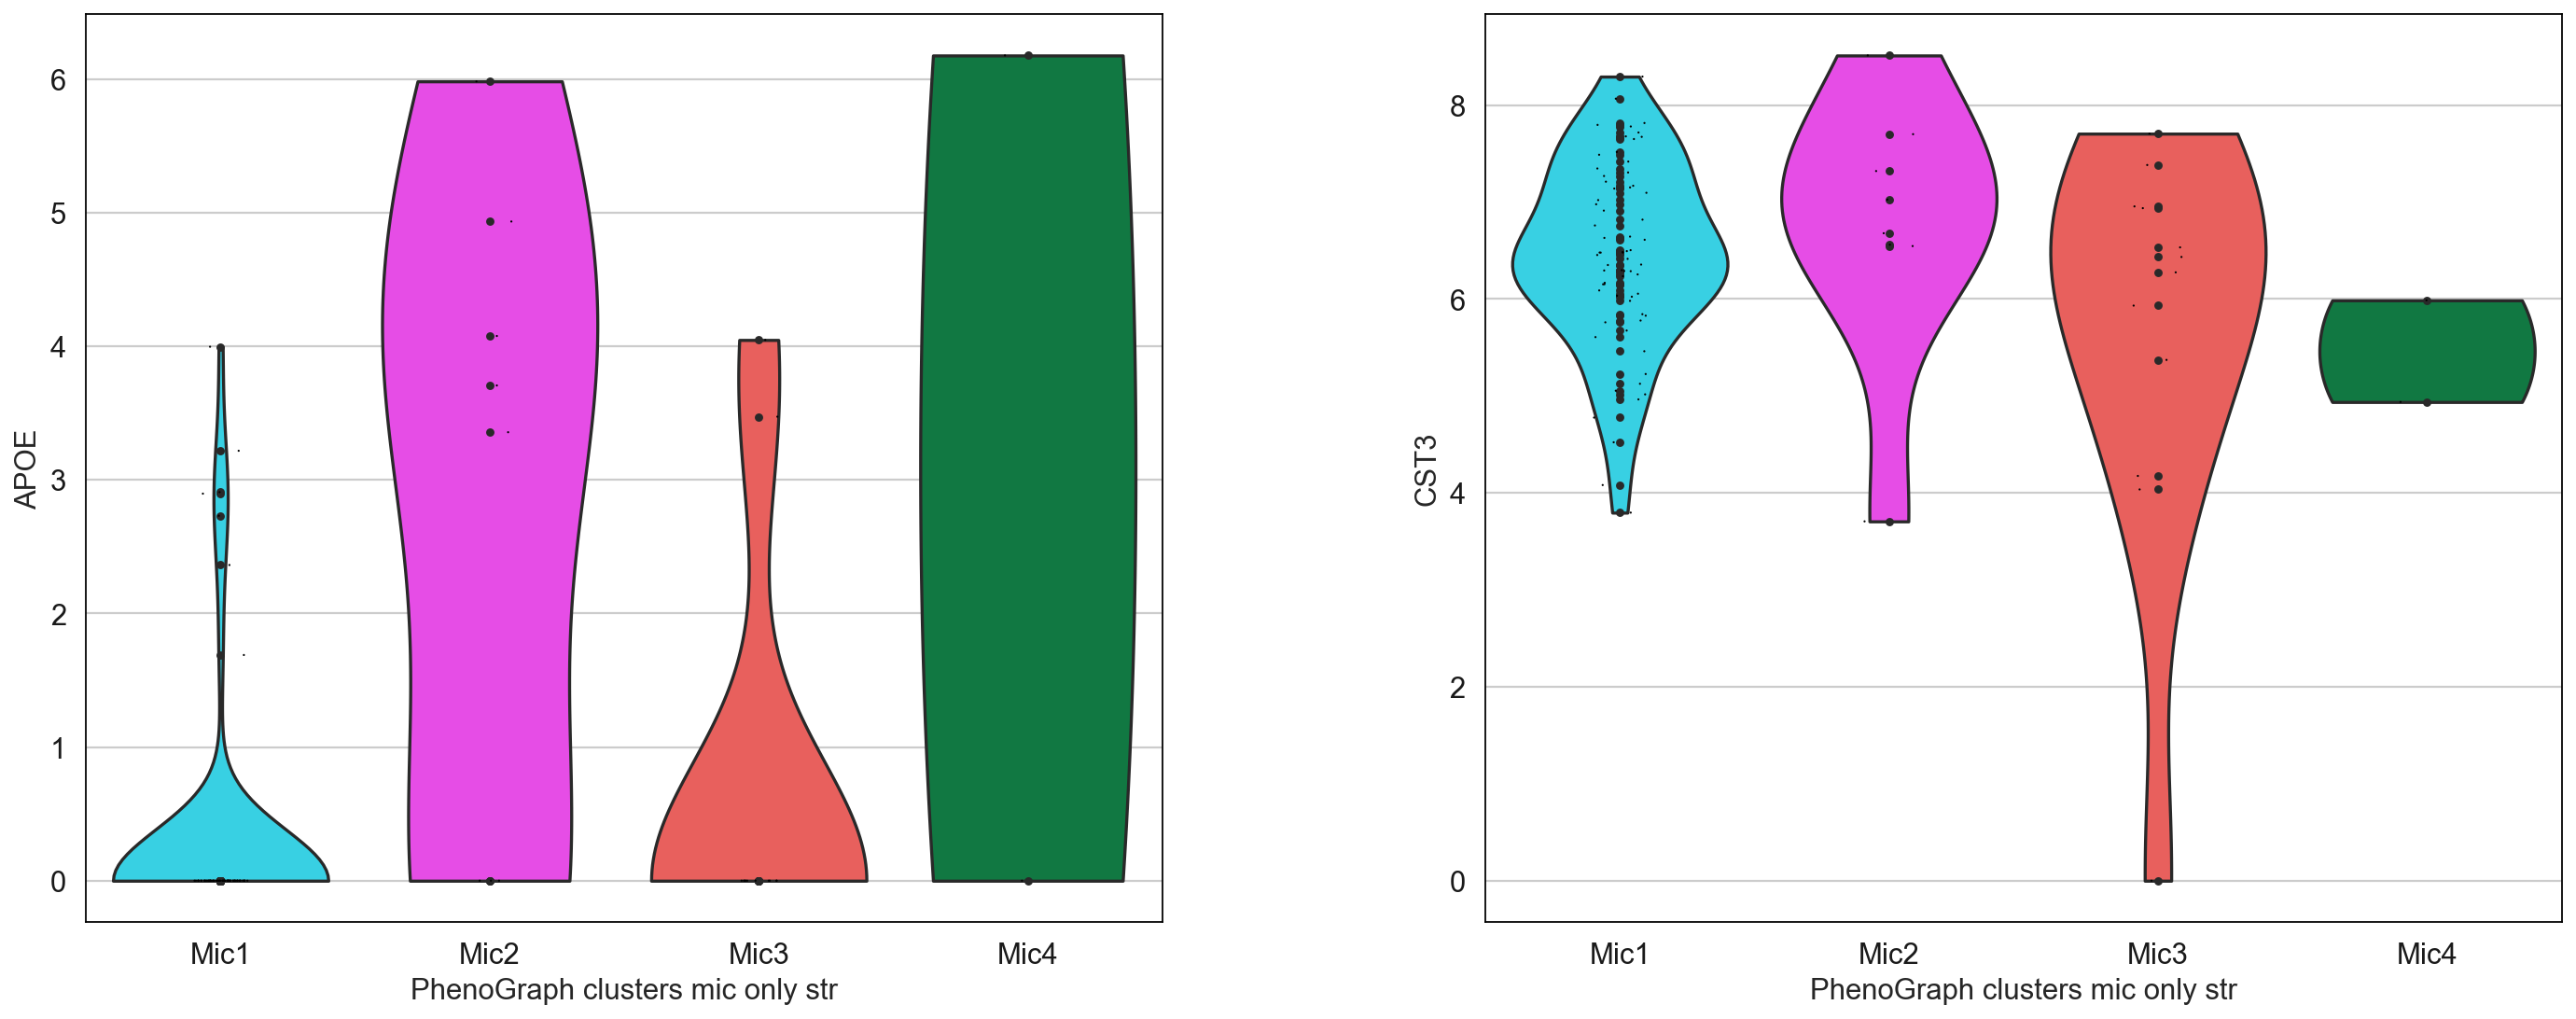

In [194]:
sc.pl.violin(adata_microglia_BS_VE, ['APOE','CST3','PCDH9'], groupby='PhenoGraph_clusters_mic_only_str', inner='point', palette = godsnot_64)
sc.pl.violin(adata_microglia_BS_Control, ['APOE','CST3'], groupby='PhenoGraph_clusters_mic_only_str', inner='point', palette  = ["#1CE6FF", "#FF34FF", "#FF4A46", "#008941"])
#"#d9d929", "#1CE6FF", "#FF34FF", "#FF4A46"